<a href="https://colab.research.google.com/github/Mikki797/Political-parties/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%20%D0%9F%D1%83%D0%BD%D0%BA%D1%82%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка данных

Подлючаем необходимые пакеты.

In [ ]:
!pip install pymorphy2
import pymorphy2
import nltk
!pip install natasha
import pandas as pd
import sklearn
import numpy as np

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 8.2 MB 9.4 MB/s 
     |████████████████████████████████| 34.4 MB 31 kB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 41 kB 113 kB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=2d1b489fcded9e0cf5092ba00f3d47c5af6a99d4391c23556a7f3f136d4ffd5d
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


В предыдущих блокнотах были проведены действия с программой КПРФ. Теперь берется несколько других партий. Где есть неинформативный заголовок программы, он удаляется.

Программа ЛДПР расположена по адресу https://ldpr.ru/party и представляет собой набор из 100 пунктов, выделенных по типу 1. . Она скопирована и сохранена в формат .txt.

"Новые люди" - https://newpeople.ru/program_newpeople , скачана в pdf и скопирована в .txt без оглавления. В ней есть пункты, веделенные символами !, ✓,ü. Есть номера строк.

Партия пенсионеров - https://minjust.gov.ru/uploaded/files/programmapartiipensionerov2017.docx , скачана в docx, скопирована в .txt , удален заголовок. Пункты выделены •, подпункты в одном месте ❖. Есть номера строк. Вариант программы на официальном сайте не использован, т.к. криво преобразуется в .txt.

Яблоко - https://www.yabloko.ru/program2021, скопирована в .txt. Пункты - 1).

Коммунисты России - https://komros.info/about/programma/. Скопирована в .txt. Есть пункты - "-".

Зеленые - https://partygreen.ru/documents/program/. Скопирована в .txt. Пункты веделены новой строкой.

Родина -https://rodina.ru/partiya/documentsForRead/37. Скопирована в .txt. Есть пункты - "-".

РПСС - https://minjust.gov.ru/uploaded/files/programmarpss.docx (на официальном сайте программы нет). Скачана в .docx и скопирована в .txt. Пункты - новые

Зеленая альтернатива - https://zaecology.ru/programma-partii/. Скопирована в .txt.

Партия роста - https://rost.ru/about/programma-partii/. Скопирована в .txt.

Гражданская платформа - http://xn--80aaag6azbdefu3lf.xn--p1ai/3363#r0.  Скопирована в .txt. Пункты - перевод строки.

Программы партий загружены на гугл диск. Программы находятся в папках с названием партий, в документах Текст.txt. Подключаемся к гугл диску и загружаем программы партий.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
party_names = ['КПРФ','ЛДПР','Новые люди','Партия пенсионеров','Яблоко','Коммунисты России','Зеленые','Родина','РПСС','Зеленая альтернатива','Партия роста','Гражданская платформа']
texts_of_program = []
for i in party_names:
  text_of_program = open('drive/MyDrive/Colab Notebooks/Проект/'+i+'/Текст.txt').read()
  texts_of_program.append(text_of_program)
  print('----------------------------------------------------------------------------------------------------------------------------------------------------')
  print(text_of_program[:100])

----------------------------------------------------------------------------------------------------------------------------------------------------
Россия находится на крутом изломе своей истории. Обманом и насилием страна возвращена к капитализму.
----------------------------------------------------------------------------------------------------------------------------------------------------
ПОЛИТИКА И ВЛАСТЬ

1. Создать специальные места для беспрепятственного собрания граждан, чтобы предс
----------------------------------------------------------------------------------------------------------------------------------------------------
Основания
Наше время – это эпоха столкновения старого и нового миров. Идет
переход от индустриальной
----------------------------------------------------------------------------------------------------------------------------------------------------
Складывающаяся сегодня в стране социальная, экономическая и демографическая ситуация продолжает брос


#Сегментация

Для анализа нужно 2 вида датасетов - данные целиком о текстах, чтобы образовать из них мешки слов, и данные о пунктах партии - что конкретно партия хочет изменить в стране. Пункты будем сохранять в каталогах партий с именем Пункты.csv.

Сегментируем тексты с помощью nltk.

In [ ]:
from nltk import sent_tokenize,word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Опять делаем функцию из работы "Лабы 2-3 Белозеров КПРФ" для корректной сегментации на предложения.

In [ ]:
def replace_in_socrashenies(text): # Сокращения имен
  symbols_list = list(text)
  for i in range(len(symbols_list)):
    if symbols_list[i]=='.': # точка между буквами имени и отчества
      if symbols_list[i-1].isupper(): # имя
        if symbols_list[i+1].isupper() and symbols_list[i+2]=='.': # отчество и точка после отчества
          symbols_list[i]='_'
          symbols_list[i+2]='_'
  return ''.join(symbols_list)
def nltk_correct_segmentation_v2(text):
  result = []
  for i in sent_tokenize(replace_in_socrashenies(text)): result.extend(i.split('\n'))
  return [i.replace('_','.') for i in result]

Разделяем тексты на предложения.

In [ ]:
nltk_sents = [nltk_correct_segmentation_v2(i) for i in texts_of_program]

##Подготовка данных

Проверяем правильность разделения на предложения.

In [ ]:
nltk_sents[0] # тут КПРФ, для него функция и сделана, так что так все правильно,

['Россия находится на крутом изломе своей истории.',
 'Обманом и насилием страна возвращена к капитализму.',
 'Это путь социального регресса, ведущий к национальной катастрофе, гибели нашей цивилизации.',
 'Коммунистическая партия Российской Федерации вела бескомпромиссную борьбу против реставрации капитализма, разрушения Союза ССР и уничтожения Советской власти.',
 'КПРФ выступает единственной политической организацией, последовательно отстаивающей права людей наёмного труда и национально-государственные интересы.',
 'Стратегическая цель партии — построение в России обновленного социализма, социализма XXI века.',
 'При определении своих программных целей и задач, стратегии и тактики наша партия исходит из анализа общественно-политической практики, руководствуется марксистско-ленинским учением и творчески его развивает, опирается на опыт и достижения отечественной и мировой науки и культуры.',
 '1.',
 'Современный мир и Россия',
 'Российские коммунисты считают, что принципиальный спор 

In [ ]:
nltk_sents[0] = [i for i in nltk_sents[0] if len(set(i))>3]

Пункты КПРФ уже выделялись, они находятся в файле КПРФ/Программа минимум.csv.

In [ ]:
punkt_frame = pd.read_csv('drive/MyDrive/Colab Notebooks/Проект/КПРФ/Программа минимум.csv',index_col=0)
punkt_frame['Пункт'] = [i[i.index('—')+1:] for i in punkt_frame['Пункт']]
punkt_frame.to_csv('drive/MyDrive/Colab Notebooks/Проект/КПРФ/Пункт.csv')
punkt_frame

,Пункт
0,"установить власть трудящихся, народно-патриот..."
1,"остановить вымирание страны, восстановить льг..."
2,национализировать природные богатства России ...
3,вернуть в Россию из зарубежных банков государ...
4,сломать систему тотальных фальсификаций при п...
5,создать реально независимую судебную систему;
6,осуществить срочную программу мер по борьбе с...
7,"пересмотреть законы, ухудшающие материальное ..."
8,восстановить ответственность власти за жилищн...
9,"увеличить финансирование науки, обеспечить уч..."


In [ ]:
nltk_sents[1]

['ПОЛИТИКА И ВЛАСТЬ',
 '',
 '1.',
 'Создать специальные места для беспрепятственного собрания граждан, чтобы представители власти слышали мнение народа.',
 '2.',
 'Проводить свободные, честные выборы только по партийным спискам, используя электронные урны.',
 'Никаких одномандатных округов!',
 '3.',
 'Избирать судей на свободных выборах.',
 'Обеспечить реальную независимость судов всех уровней.',
 '4.',
 'Сформировать в стране 30 губерний.',
 'Никакого деления по национальному признаку.',
 'В каждой губернии создать представительный орган власти — губернские думы.',
 '5.',
 'Назначать премьер-министром лидера партии, победившей на выборах в Госдуму.',
 'Больше денег направлять в регионы, малые города и поселки.',
 '6.',
 'Расширить функции Госсовета, который должен принимать стратегические решения.',
 'Мы должны опережать негативные события и факторы.',
 '7.',
 'Обязать любого руководителя брать заместителей из оппозиционных парламентских партий.',
 'Закрепить за оппозицией функции над

Удаляем непонятный символ \u202f и обозначения пунктов. Попутно выделяем пункты и области, которым они пренадлежат (разделы пунктов), области выделены капсом.

In [ ]:
nltk_sents[1] = [i.replace('\u202f',' ') for i in nltk_sents[1]]
caps = [i for i in nltk_sents[1] if i.isupper()] # разделы пунктов
nltk_sents[1] = [i.replace('\u202f',' ') for i in nltk_sents[1] if len(i)>4]
nltk_sents[1]

['ПОЛИТИКА И ВЛАСТЬ',
 'Создать специальные места для беспрепятственного собрания граждан, чтобы представители власти слышали мнение народа.',
 'Проводить свободные, честные выборы только по партийным спискам, используя электронные урны.',
 'Никаких одномандатных округов!',
 'Избирать судей на свободных выборах.',
 'Обеспечить реальную независимость судов всех уровней.',
 'Сформировать в стране 30 губерний.',
 'Никакого деления по национальному признаку.',
 'В каждой губернии создать представительный орган власти — губернские думы.',
 'Назначать премьер-министром лидера партии, победившей на выборах в Госдуму.',
 'Больше денег направлять в регионы, малые города и поселки.',
 'Расширить функции Госсовета, который должен принимать стратегические решения.',
 'Мы должны опережать негативные события и факторы.',
 'Обязать любого руководителя брать заместителей из оппозиционных парламентских партий.',
 'Закрепить за оппозицией функции надзора и контроля.',
 'Вместо главы Счетной палаты ввест

In [ ]:
punkts_v1 = [i for i in texts_of_program[1].split('\n') if len(i)>0]
print(punkts_v1)
print(caps)
punkts = []
j = 0 # Номер раздела пунктов
for i in punkts_v1[1:]:
  if i.isupper():
    j = j+1
  else:
    punkts.append((i[i.index(' '):],caps[j]))
punkt_df = pd.DataFrame(punkts,columns=['Пункт','Тема'])
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[1]+'/Пункт.csv')
punkt_df

['ПОЛИТИКА И ВЛАСТЬ', '1. Создать специальные места для беспрепятственного собрания граждан, чтобы представители власти слышали мнение народа.', '2. Проводить свободные, честные выборы только по партийным спискам, используя электронные урны. Никаких одномандатных округов!', '3. Избирать судей на свободных выборах. Обеспечить реальную независимость судов всех уровней.', '4. Сформировать в стране 30 губерний. Никакого деления по национальному признаку. В каждой губернии создать представительный орган власти — губернские думы.', '5. Назначать премьер-министром лидера партии, победившей на выборах в Госдуму. Больше денег направлять в регионы, малые города и поселки.', '6. Расширить функции Госсовета, который должен принимать стратегические решения. Мы должны опережать негативные события и факторы.', '7. Обязать любого руководителя брать заместителей из оппозиционных парламентских партий. Закрепить за оппозицией функции надзора и контроля.', '8. Вместо главы Счетной палаты ввести должность 

,Пункт,Тема
0,Создать специальные места для беспрепятственн...,ПОЛИТИКА И ВЛАСТЬ
1,"Проводить свободные, честные выборы только по...",ПОЛИТИКА И ВЛАСТЬ
2,Избирать судей на свободных выборах. Обеспечи...,ПОЛИТИКА И ВЛАСТЬ
3,Сформировать в стране 30 губерний. Никакого д...,ПОЛИТИКА И ВЛАСТЬ
4,"Назначать премьер-министром лидера партии, по...",ПОЛИТИКА И ВЛАСТЬ
...,...,...
96,Создать условия для развития массового фермер...,МАЛЫЙ И СРЕДНИЙ БИЗНЕС
97,"Списать некоторые долги частным фермерам, что...",МАЛЫЙ И СРЕДНИЙ БИЗНЕС
98,Снизить стоимость аренды площадей для малого ...,МАЛЫЙ И СРЕДНИЙ БИЗНЕС
99,Не взимать налоги с малого бизнеса в течение ...,МАЛЫЙ И СРЕДНИЙ БИЗНЕС


In [ ]:
nltk_sents[2] # Новые люди

['Основания',
 'Наше время – это эпоха столкновения старого и нового миров.',
 'Идет',
 'переход от индустриальной фазы развития общества, когда ключевым',
 'ресурсом была собственность на средства производства, к',
 'информационной, когда таким ресурсом оказалось владение информацией',
 'и средствами коммуникации.',
 'Мир становится все сложнее.',
 'Развитые страны уперлись в фазовый барьер',
 '– пределы роста, когда институты госуправления больше не отвечают',
 'возрастающей сложности процессов.',
 'Они реагируют закручиванием гаек и',
 'усилением контроля.',
 'Но такой подход работает по историческим меркам недолго.',
 'От',
 'упрощения мира выигрывают лишь национальные и транснациональные',
 'элиты.',
 'А люди живут все хуже: качество жизни падает, свободы все',
 'меньше.',
 'В перспективе это путь в никуда – к закату цивилизации.',
 'Новые вызовы требуют новых ответов.',
 'В нынешней ситуации под угрозой',
 'оказывается то, что еще недавно, даже в самые кровавые эпохи,',
 'восприн

В тексте программы переводы строки посреди предложения. Заменяем их на пробел. Чтобы при этом отделить заголовки, добавляем точк Удаляем пункты. Удаляем номера страниц.  Раскрываем одно сокращение "т.н.".

In [ ]:
tmp = [i for i in texts_of_program[2].replace('т.н.','так называемые').split('\n') if len(i)>2] # удаляем номера страниц
zagolovki = ['Основания','Политическое устройство','Обеспечить конкурентность','Провести децентрализацию','Закрепить приоритет избранной власти','Экономика'
,'Увеличить доходы','Развивать инновации','Совершить структурный маневр','Избавиться от административного пресса','Безопасность и правопорядок'
,'Выбирать руководителей силовых органов','Обеспечить прозрачность','Отменить «палочную» систему','Гуманизировать правосудие','Оборона страны',
'Перевооружить армию','Повысить профессионализм','Повысить престиж военной службы','Здравоохранение','Совершенствовать систему профилактики',
'Повысить качество услуг','Внедрять технологии','Гарантировать добровольность вакцинации','Образование','Обеспечить учителям достойную оплату труда',
'Повысить качество образования, обеспечить разнообразие вариантов обучения','Внедрять новые формы управления','Экология','Повышать экологичность городов',
'Развивать внутренний туризм','Стимулировать экологичное поведение','Внешняя политика']
tmp2 = []
for i in tmp:
  if i in zagolovki: tmp2.append(i+'.')
  else: tmp2.append(i)
nltk_sents[2] = nltk_correct_segmentation_v2(' '.join(tmp2))
nltk_sents[2] = [i for i in nltk_sents[2] if len(i)>4]
nltk_sents[2]

['Основания.',
 'Наше время – это эпоха столкновения старого и нового миров.',
 'Идет переход от индустриальной фазы развития общества, когда ключевым ресурсом была собственность на средства производства, к информационной, когда таким ресурсом оказалось владение информацией и средствами коммуникации.',
 'Мир становится все сложнее.',
 'Развитые страны уперлись в фазовый барьер – пределы роста, когда институты госуправления больше не отвечают возрастающей сложности процессов.',
 'Они реагируют закручиванием гаек и усилением контроля.',
 'Но такой подход работает по историческим меркам недолго.',
 'От упрощения мира выигрывают лишь национальные и транснациональные элиты.',
 'А люди живут все хуже: качество жизни падает, свободы все меньше.',
 'В перспективе это путь в никуда – к закату цивилизации.',
 'Новые вызовы требуют новых ответов.',
 'В нынешней ситуации под угрозой оказывается то, что еще недавно, даже в самые кровавые эпохи, воспринималось как само собой разумеющееся: возможност

У партии очень проблемная программа, так что оставим эту задачу на будущее. Вообще судя по всему там надо парсить сайт.

In [ ]:
party_names[3]

'Партия пенсионеров'

In [ ]:
nltk_sents[3]

['Складывающаяся сегодня в стране социальная, экономическая и демографическая ситуация продолжает бросать вызов большинству граждан России.',
 'Сочетание многообразных внешних угроз с накопившимися внутренними проблемами неизбежно подталкивает нас к реальному и существенному переосмыслению политических взглядов и позиций, как каждого отдельного гражданина, так и политических партий, и, особенно, представительных органов власти всех уровней.',
 'Итоги выборов в Государственную Думу Федерального Собрания Российской Федерации седьмого созыва показали, что граждане хорошо понимают – сложившая политическая система испытывает острый дефицит новых лиц и продуманных решений, а практика обновлений депутатского корпуса далеко не всегда эффективна.',
 'Выборы показали также, что граждане действительно нуждаются в партийных силах, реально представляющих интересы широких слоев населения, слабозащищенных групп граждан, пенсионеров.',
 'Число последних неуклонно растет, а количество трудоспособного н

Раскрываем сокращения, удаляем нераспознанные символы табуляции и еще чего-то.

In [ ]:
nltk_sents[3] = nltk_correct_segmentation_v2(texts_of_program[3].replace('\t',' ').replace('т. п.','тому подобное').replace('т. д.','так далее')
.replace('\uf076',' ').replace('гл.','главу'))
nltk_sents[3] = [i for i in nltk_sents[3] if len(i)>2]
nltk_sents[3]

['Складывающаяся сегодня в стране социальная, экономическая и демографическая ситуация продолжает бросать вызов большинству граждан России.',
 'Сочетание многообразных внешних угроз с накопившимися внутренними проблемами неизбежно подталкивает нас к реальному и существенному переосмыслению политических взглядов и позиций, как каждого отдельного гражданина, так и политических партий, и, особенно, представительных органов власти всех уровней.',
 'Итоги выборов в Государственную Думу Федерального Собрания Российской Федерации седьмого созыва показали, что граждане хорошо понимают – сложившая политическая система испытывает острый дефицит новых лиц и продуманных решений, а практика обновлений депутатского корпуса далеко не всегда эффективна.',
 'Выборы показали также, что граждане действительно нуждаются в партийных силах, реально представляющих интересы широких слоев населения, слабозащищенных групп граждан, пенсионеров.',
 'Число последних неуклонно растет, а количество трудоспособного н

Выделяем пункты. Тут они разделены на "партия выступает за" и "партия выступает против". Пока что не заморачиваемся с доставанием всех предложений из каждого пункта, потому что первое предложение обычно достаточно хорошо характеризует пункт.

In [ ]:
party_za = True
punkts = []
razdels = ['Социальная политика:','Пенсионная реформа:','Реформа здравоохранения:','Реформа образования и социальная адаптация:','Экономическая политика:',
           'Промышленная политика:','Сельское хозяйство :','ЖКХ и жилищная политика:']
for i in nltk_sents[3]:
  if i in razdels: current_razdel = i
  else:
    if i.startswith('•') and party_za:
      punkts.append((i[i.index('•')+2:],current_razdel))
    elif i=='Партия выступает за:': party_za = True
    elif i=='Партия выступает против:': party_za = False

punkt_df = pd.DataFrame(punkts,columns=['Пункт','Тема'])
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[3]+'/Пункт.csv')
punkt_df

,Пункт,Тема
0,максимальное вовлечение общественности в обсуж...,Пенсионная реформа:
1,устранение разрыва между размерами пенсионных ...,Пенсионная реформа:
2,"создание единого, прозрачного и неизменяемого ...",Пенсионная реформа:
3,создание государственного фонда пенсионного ин...,Пенсионная реформа:
4,коренной пересмотр инвестиционной политики гос...,Пенсионная реформа:
...,...,...
103,увеличение объемов строительства наемных много...,ЖКХ и жилищная политика:
104,установку в квартирах пенсионеров и семей соци...,ЖКХ и жилищная политика:
105,отмену пеней за 6 месяцев задержки оплаты ЖКУ ...,ЖКХ и жилищная политика:
106,коренной потенциальный пересмотр всего блока ж...,ЖКХ и жилищная политика:


In [ ]:
nltk_sents[4]

['ПРОГРАММА АЛЬТЕРНАТИВНОГО КУРСА РАЗВИТИЯ РОССИИ',
 'Политика президента Владимира Путина – это путь в тупик.',
 'Это неограниченная власть чиновников, международная изоляция и вражда с соседями, бесправные люди, отсталая экономика, не способная обеспечить высокое качество и уровень жизни граждан.',
 '«Яблоко» предлагает принципиально другую политику и готово ее осуществить.',
 'Мы – за  человека и его права, за уважение к людям, за жизнь без страха и репрессий, за современное правовое российское государство.',
 'Мы – за доступную первоклассную медицину, науку и образование мирового уровня, за современную экономику, за мир.',
 '1.',
 'СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ СТРАХА',
 '1) Политическая свобода.',
 'Освобождение всех политических заключенных.',
 'Отмена репрессивных законов, ограничивающих права и свободы человека и гражданина.',
 'Отмена «обнуления» президентских сроков и восстановление конституционного порядка.',
 'Свобода собраний и митингов.',
 'Десталинизация

Тут просто удаляем некоторые номера заголовков.

In [ ]:
nltk_sents[4] = [i for i in nltk_sents[4] if len(i)>2]

Пункты выделяем, заголовки - капс.

In [ ]:
punkts_v1 = [i for i in texts_of_program[4].split('\n') if len(i)>0]
punkts = []
for i in punkts_v1:
  if i.isupper():
    current_razdel = i
  elif 0<i.find(')')<3:
    punkts.append((i[i.index(' '):],current_razdel[3:]))
punkt_df = pd.DataFrame(punkts,columns=['Пункт','Тема'])
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[4]+'/Пункт.csv')
punkt_df

,Пункт,Тема
0,Политическая свобода. Освобождение всех полит...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
1,Раскрытие политических преступлений. Расследо...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
2,"Судебная реформа. Независимость суда, выборно...","СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
3,Сменяемость власти и честные выборы. Разделен...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
4,Свобода слова и творчества. Запрет на все вид...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
5,Антимонопольная политика и реформа государств...,СОВРЕМЕННАЯ ЭКОНОМИКА
6,Неприкосновенность частной собственности и ра...,СОВРЕМЕННАЯ ЭКОНОМИКА
7,Экономика знаний. Налоговое стимулирование вы...,СОВРЕМЕННАЯ ЭКОНОМИКА
8,Противодействие коррупции. Сокращение закрыты...,СОВРЕМЕННАЯ ЭКОНОМИКА
9,Программа «Дома–Земля–Дороги». Безвозмездная ...,СОВРЕМЕННАЯ ЭКОНОМИКА


In [ ]:
nltk_sents[5]

['КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ (далее – Партия) представляет собой общественное объединение, созданное в целях участия граждан Российской Федерации, поддерживающих цели и задачи Партии, в политической жизни общества посредством формирования и выражения политической воли, участия в общественных и политических акциях, в выборах и референдумах, а также в целях представления интересов пролетариата в органах государственной власти и органах местного самоуправления.',
 'Партия ведет свою идейную родословную от «Союза борьбы за освобождение рабочего класса», РСДРП (б), РКП (б), ВКП (б) и КПСС.',
 'Своим идейно-теоретическим базисом Партия считает труды К.Маркса, Ф.Энгельса, В.И.Ленина и И.В.Сталина и видит одной из главных своих задач пропаганду и дальнейшее развитие их теоретического наследия с учетом реалий ХХI века.',
 'Партия имеет своими стратегическими целями возврат России на путь социалистического развития, воссоздание Союзного социалистического государства , воссоздание 

Тут совсем чуть-чуть пунктов, так что они выделяются вручную копированием.

In [ ]:
proba = 'слом буржуазной государственной машины управления обществом, обеспечение подлинного народовластия, передача всей полноты власти самим трудящимся и их органам самоуправления (Советам); принятие социалистической Конституции. - проведение национализации важнейших объектов собственности: земли, всех природных ресурсов, добывающей промышленности, энергосистемы, транспорта, ВПК, стратегических и наукоемких производств, банковской системы, внешней торговли; национализация производства, хранения и реализации лекарственных средств. - ликвидация всех форм эксплуатации, всех паразитических доходов; - формирование и расширение государственного сектора реальной экономики на основе разработок и внедрения высокотехнологичных средств производства; - усиление государственного контроля и его эффективности за деятельностью банков, предприятий и учреждений всех форм собственности и соблюдением норм трудового законодательства; - восстановление социальных гарантий: права на труд, на доступное бесплатное образование, медицинскую помощь, отдых, жилье, на своевременное пенсионное обеспечение - введение закона «О сверхдоходах»; - Введение в систему социальной защиты населения понятия безусловный доход - - Всемерная защита окружающей среды, вовлечение всего населения страны в  обеспечение экологической безопасности и сохранения природных ресурсов для будущих поколений - принятие радикальных мер по улучшению качества жизни беднейших и малообеспеченных слоёв населения; - принятие решительных мер по охране детства; - принятие комплексных  решительных мер против продолжающейся наркотизации населения;'
punkts = [i for i in proba.split('-') if len(i)>1]
punkt_df = pd.DataFrame({'Пункт':punkts})
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[5]+'/Пункт.csv')
punkt_df

,Пункт
0,слом буржуазной государственной машины управле...
1,проведение национализации важнейших объектов ...
2,"ликвидация всех форм эксплуатации, всех параз..."
3,формирование и расширение государственного се...
4,усиление государственного контроля и его эффе...
5,восстановление социальных гарантий: права на ...
6,введение закона «О сверхдоходах»;
7,Введение в систему социальной защиты населени...
8,"Всемерная защита окружающей среды, вовлечение..."
9,принятие радикальных мер по улучшению качеств...


In [ ]:
nltk_sents[6]

['I. ОБЩИЕ ПОЛОЖЕНИЯ',
 '',
 '         Российская экологическая партия «Зеленые» — это объединение граждан Российской Федерации, убежденных в том, что экологически ориентированный, конструктивный и системный подход к политическим, экономическим, социальным и другим общественным отношениям является единственно приемлемым для развития Российского государства.',
 'Российская экологическая партия «Зеленые» — общественное объединение сторонников взвешенных и последовательных действий, направленных на экологичное развитие производительных сил единой и сильной России, бережное и эффективное использование ее природных ресурсов и охрану природы, создание условий здоровой и достойной жизни населения страны.',
 'Российская экологическая партия «Зеленые» — организация, осознающая необходимость совместных комплексных действий всех слоев общества и власти, ведущая к их открытому и конструктивному диалогу, выступающая за системный подход к решению экологических и других, неизбежно связанных с ними, о

In [ ]:
nltk_sents[6] = [i for i in nltk_sents[6] if len(i)>3 and len(set(i))>3]
nltk_sents[6]

['I. ОБЩИЕ ПОЛОЖЕНИЯ',
 '         Российская экологическая партия «Зеленые» — это объединение граждан Российской Федерации, убежденных в том, что экологически ориентированный, конструктивный и системный подход к политическим, экономическим, социальным и другим общественным отношениям является единственно приемлемым для развития Российского государства.',
 'Российская экологическая партия «Зеленые» — общественное объединение сторонников взвешенных и последовательных действий, направленных на экологичное развитие производительных сил единой и сильной России, бережное и эффективное использование ее природных ресурсов и охрану природы, создание условий здоровой и достойной жизни населения страны.',
 'Российская экологическая партия «Зеленые» — организация, осознающая необходимость совместных комплексных действий всех слоев общества и власти, ведущая к их открытому и конструктивному диалогу, выступающая за системный подход к решению экологических и других, неизбежно связанных с ними, основн

Заметка, у коммунистов России и у зеленых защита окружающей среды "всемерная". Вообще у зеленых все очень странно, у них есть длинный список пунктов, но они относятся не к тому, что надо сделать со страной, а что партия делает прямо сейчас.

In [ ]:
punkts = nltk_sents[6][nltk_sents[6].index('         Объединение и выступление единым фронтом всех общественных сил и граждан, обеспокоенных проблемами окружающей среды.'):
nltk_sents[6].index('ПРИНЦИПЫ ПАРТИЙНОЙ ИДЕОЛОГИИ')]
punkts = [i.lstrip() for i in punkts]
punkt_df = pd.DataFrame({'Пункт':punkts})
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[6]+'/Пункт.csv')
punkt_df

,Пункт
0,Объединение и выступление единым фронтом всех ...
1,Создание условий и постоянных институтов систе...
2,"Выработка, совершенствование и осуществление д..."
3,Политическое содействие установлению справедли...
4,Развитие экологического мировоззрения граждан ...
5,Политическое содействие созданию и внедрению в...
6,Создание условий стабильного повышения качеств...
7,Всемерное содействие укреплению и существенном...
8,Последовательное и целенаправленное внедрение ...
9,Развитие и усиление международных связей в сфе...


In [ ]:
nltk_sents[7]

['ПАРТИЯ «РОДИНА» - НАЦИОНАЛЬНЫЙ ФРОНТ',
 '',
 'ПРЕДВЫБОРНЫЙ МАНИФЕСТ-2016',
 '',
 'Отечество в опасности!',
 'Вновь враги России мобилизуют свои силы и за границей, и внутри страны.',
 'Власти государств, еще вчера считавшиеся нашими партнерами, сегодня проводят откровенную русофобскую и антироссийскую политику.',
 'Экономические санкции, непризнание возвращения Крыма в Россию, «мельдониевая истерика» против наших спортсменов-олимпийцев, приближение НАТО к границам РФ и перевооружение стран-участниц альянса на фоне бесконечных рекламных роликов про «русскую угрозу», агрессивные заявления против Путина и России – все эти вызовы Запад выдает в ежедневном режиме и в промышленных масштабах, наплевав на разум, здравый смысл и экономические интересы.',
 'А в самой России копошатся и поднимают головы старые опарыши прозападного либерал-глобализма, желающие вновь поживиться за счет общероссийской национальной катастрофы наподобие 1917 и 1991 годов.',
 'Партия «РОДИНА» не позволит сбыться этим

In [ ]:
nltk_sents[7] = [i for i in nltk_sents[7] if len(i)>3]
nltk_sents[7]

['ПАРТИЯ «РОДИНА» - НАЦИОНАЛЬНЫЙ ФРОНТ',
 'ПРЕДВЫБОРНЫЙ МАНИФЕСТ-2016',
 'Отечество в опасности!',
 'Вновь враги России мобилизуют свои силы и за границей, и внутри страны.',
 'Власти государств, еще вчера считавшиеся нашими партнерами, сегодня проводят откровенную русофобскую и антироссийскую политику.',
 'Экономические санкции, непризнание возвращения Крыма в Россию, «мельдониевая истерика» против наших спортсменов-олимпийцев, приближение НАТО к границам РФ и перевооружение стран-участниц альянса на фоне бесконечных рекламных роликов про «русскую угрозу», агрессивные заявления против Путина и России – все эти вызовы Запад выдает в ежедневном режиме и в промышленных масштабах, наплевав на разум, здравый смысл и экономические интересы.',
 'А в самой России копошатся и поднимают головы старые опарыши прозападного либерал-глобализма, желающие вновь поживиться за счет общероссийской национальной катастрофы наподобие 1917 и 1991 годов.',
 'Партия «РОДИНА» не позволит сбыться этим вражеским

In [ ]:
punkts_v1 = nltk_sents[7][:nltk_sents[7].index('ПЕРВООЧЕРЕДНЫЕ ЗАКОНЫ «РОДИНЫ»')]
punkts = []
for i in punkts_v1:
  if i.endswith(' «РОДИНА» предлагает'):
    current_razdel = i.replace('В сфере ','').replace(' «РОДИНА» предлагает','')
  elif i.startswith('- '):
    punkts.append((i[2:],current_razdel))
punkt_df = pd.DataFrame(punkts,columns=['Пункт','Тема'])
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[7]+'/Пункт.csv')
punkt_df

,Пункт,Тема
0,принять закон о Социальном стандарте достойной...,социальной и пенсионной политики
1,установить стартовый (минимальный) предел опла...,социальной и пенсионной политики
2,увеличить долю заработной платы в структуре ВВ...,социальной и пенсионной политики
3,удвоить зарплаты и пенсиив течение 3-х лет за ...,социальной и пенсионной политики
4,после повышения оплаты труда пересмотреть ране...,социальной и пенсионной политики
...,...,...
110,"предоставить гражданам, прошедшим срочную воен...",В оборонно-промышленной и военной сферах
111,считать главными целями внешней политики Росси...,внешней политики
112,законодательно обеспечить безусловное право Ро...,внешней политики
113,"добиваться международного признания того, что ...",внешней политики


В программе следующей партии нет пунктов.

In [ ]:
nltk_sents[8]

['Наша цель – превращение Российской Федерации в полноценное социалистическое государство без угнетателей и угнетенных',
 'Мы намерены превратив Россию в социально-ответственное государство, заботящееся о своем народе.',
 'Политическая партия «РОССИЙСКАЯ ПАРТИЯ СВОБОДЫ И СПРАВЕДЛИВОСТИ» построит общество, где не будет нищеты и богатства, где труд будет достойно вознаграждаться, где у каждого будут возможности для развития, где человек будет уверен в своем будущем.',
 'Народное государство ',
 'Презрение к интересам людей, отчуждение власти от народа, коррупция, наращивание бюрократического аппарата - признаки порочности государственной системы.',
 'Политическая партия «РОССИЙСКАЯ ПАРТИЯ СВОБОДЫ И СПРАВЕДЛИВОСТИ» кардинально изменит политику государства в интересах народа.',
 'Благо людей - вот, что должно стать основной целью существования государства.',
 'Социальная справедливость',
 'Общество должно строиться на принципах социальной справедливости.',
 'Наша цель - ускоренное движение

In [ ]:
nltk_sents[9]

['Общие положения',
 'Политическая партия ЗЕЛЕНАЯ АЛЬТЕРНАТИВА — партия новой волны, приоритетом которой является охрана природы России и продвижение экологических ценностей на всех уровнях власти и общественного диалога.',
 'Партия открыта для всех граждан, которых заботит состояние окружающей среды, которых беспокоит здоровое будущее самого большого и одного из самых богатых природными ресурсами государств мира.',
 'Ценности чистоты и безопасности универсальны и важны для всех, это пора понимать в XXI веке и об этом необходимо говорить на самом высоком уровне.',
 'Политическая партия ЗЕЛЕНАЯ АЛЬТЕРНАТИВА ведёт работу в регионах страны, выделяет значимые проблемы, экологические угрозы, требует их решения, добивается принятия экологических законодательных актов, соблюдения законодательства в отношении охраны природы, выступает за продвижение и укрепление экологических образовательных программ, распространение экологической культуры.',
 'Политика должна ориентироваться на природу, не то

Удаляем символы \u202f.

In [ ]:
nltk_sents[9] = nltk_correct_segmentation_v2(texts_of_program[9].replace('\u202f',' '))
nltk_sents[9] = [i for i in nltk_sents[9] if len(i)>1]
nltk_sents[9]

['Общие положения',
 'Политическая партия ЗЕЛЕНАЯ АЛЬТЕРНАТИВА — партия новой волны, приоритетом которой является охрана природы России и продвижение экологических ценностей на всех уровнях власти и общественного диалога.',
 'Партия открыта для всех граждан, которых заботит состояние окружающей среды, которых беспокоит здоровое будущее самого большого и одного из самых богатых природными ресурсами государств мира.',
 'Ценности чистоты и безопасности универсальны и важны для всех, это пора понимать в XXI веке и об этом необходимо говорить на самом высоком уровне.',
 'Политическая партия ЗЕЛЕНАЯ АЛЬТЕРНАТИВА ведёт работу в регионах страны, выделяет значимые проблемы, экологические угрозы, требует их решения, добивается принятия экологических законодательных актов, соблюдения законодательства в отношении охраны природы, выступает за продвижение и укрепление экологических образовательных программ, распространение экологической культуры.',
 'Политика должна ориентироваться на природу, не то

In [ ]:
punkts_v1 = texts_of_program[9].split('\n')
punkts_v1 = [i.replace('ЗЕЛЕНАЯ АЛЬТЕРНАТИВА','') for i in punkts_v1[punkts_v1.index('Образование'):]]
razdels = ['Образование','Экономика','Здравоохранение','Развитие территорий.']
punkts = []
for i in punkts_v1:
  if i in razdels:
    current_razdel = i
  elif len(i)>0:
    punkts.append((i,current_razdel))
punkt_df = pd.DataFrame(punkts,columns=['Пункт','Тема'])
punkt_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/'+party_names[9]+'/Пункт.csv')
punkt_df

,Пункт,Тема
0,Экологическая программа должна быть официально...,Образование
1,Также экологическая составляющая должна быть в...,Образование
2,"Помимо этого, целям экологического просвещения...",Образование
3,Граждане России должны понимать как риски угро...,Образование
4,Экологические интересы и приоритеты должны вли...,Экономика
5,Налоговая нагрузка на предприятия должна обяза...,Экономика
6,Политическая партия против «сырьевых вампиров...,Экономика
7,Мы понимаем риски всемирного глобального измен...,Экономика
8,Россия может и должна быть страной здоровых пр...,Экономика
9,"Появление новых болезней и вирусов, огромное к...",Здравоохранение


In [ ]:
nltk_sents[10]

['РОССИЯ МОЖЕТ БЫТЬ ДРУГОЙ!',
 'ПРОГРАММА 2020 ',
 '',
 'ЛЮДИ ДЕЛА ',
 '',
 'Мы – «ПАРТИЯ РОСТА», партия ЛЮДЕЙ ДЕЛА   ',
 '',
 'Тех, кто создаёт новое – рабочие места, предприятия, материальные, социальные, культурные ценности.',
 'Мы – партия знающих себе цену, думающих, предприимчивых, социально активных граждан, тех, кто привык достигать результата сам.',
 'Мы – партия производящего класса России, голос конкурентного, независимого от государства бизнеса не двух десятков крупных сырьевых корпораций, а сотен тысяч малых, средних и крупных предприятий, призванного составлять основу среднего класса общества.',
 'Мы - их представитель в политическом пространстве страны.',
 'Мы - партия практиков и прагматиков, которые "знают как", каждый в своем деле добился результата, и мы знаем, как добиться успеха для всей страны.',
 'Мы готовы без ложных обещаний и популизма взять на себя ответственность за необходимые в России преобразования.',
 'Мы идём в политику для того, чтобы не допустить скат

In [ ]:
nltk_sents[10] = [i for i in nltk_sents[10] if len(i)>3 and set(i)!={' ','I','.'}]
nltk_sents[10]

['РОССИЯ МОЖЕТ БЫТЬ ДРУГОЙ!',
 'ПРОГРАММА 2020 ',
 'ЛЮДИ ДЕЛА ',
 'Мы – «ПАРТИЯ РОСТА», партия ЛЮДЕЙ ДЕЛА   ',
 'Тех, кто создаёт новое – рабочие места, предприятия, материальные, социальные, культурные ценности.',
 'Мы – партия знающих себе цену, думающих, предприимчивых, социально активных граждан, тех, кто привык достигать результата сам.',
 'Мы – партия производящего класса России, голос конкурентного, независимого от государства бизнеса не двух десятков крупных сырьевых корпораций, а сотен тысяч малых, средних и крупных предприятий, призванного составлять основу среднего класса общества.',
 'Мы - их представитель в политическом пространстве страны.',
 'Мы - партия практиков и прагматиков, которые "знают как", каждый в своем деле добился результата, и мы знаем, как добиться успеха для всей страны.',
 'Мы готовы без ложных обещаний и популизма взять на себя ответственность за необходимые в России преобразования.',
 'Мы идём в политику для того, чтобы не допустить скатывания страны в

Вообщем с партией роста тоже подожду пункты извлекать.

In [ ]:
nltk_sents[11]

['1.',
 'ИДЕОЛОГИЧЕСКАЯ ПЛАТФОРМА',
 '1.1.',
 'Россия и мир',
 'Мир находится в расщеплённом состоянии и стоит на пороге грандиозных преобразований.',
 'Фундаментальный кризис нынешней глобальной экономики и существующей финансовой пирамиды свидетельствует об умирании послевоенного миропорядка.',
 'Тотальное господство одной страны и жёсткое сопротивление гегемона плавным изменениям миропорядка привели к колоссальным дисбалансам в мировой экономике, многочисленным затяжным вооружённым конфликтам, неконтролируемым миграционным потокам, глубокому кризису ценностных ориентиров молодого поколения.',
 'Власти гегемона отдают себе отчёт в том, что их контроль над миром становится всё более эфемерным.',
 'Поэтому их главной задачей сегодня и в ближайшем будущем является нанесение максимального ущерба тем странам, которые вскоре могут подхватить падающее знамя.',
 'Экономическое давление, финансовые ограничения, подрывная деятельность, создание зон нестабильности – арсенал применяемых средств 

Удаляем надпись с сайта "Наверх" и тот символ.

In [ ]:
nltk_sents[11] = nltk_correct_segmentation_v2(texts_of_program[11].replace('т. д.','так далее').replace('\u202f',' '))
nltk_sents[11] = [i for i in nltk_sents[11] if len(i)>4 and len(set(i))>4 and i!='Наверх']
nltk_sents[11]

['ИДЕОЛОГИЧЕСКАЯ ПЛАТФОРМА',
 'Россия и мир',
 'Мир находится в расщеплённом состоянии и стоит на пороге грандиозных преобразований.',
 'Фундаментальный кризис нынешней глобальной экономики и существующей финансовой пирамиды свидетельствует об умирании послевоенного миропорядка.',
 'Тотальное господство одной страны и жёсткое сопротивление гегемона плавным изменениям миропорядка привели к колоссальным дисбалансам в мировой экономике, многочисленным затяжным вооружённым конфликтам, неконтролируемым миграционным потокам, глубокому кризису ценностных ориентиров молодого поколения.',
 'Власти гегемона отдают себе отчёт в том, что их контроль над миром становится всё более эфемерным.',
 'Поэтому их главной задачей сегодня и в ближайшем будущем является нанесение максимального ущерба тем странам, которые вскоре могут подхватить падающее знамя.',
 'Экономическое давление, финансовые ограничения, подрывная деятельность, создание зон нестабильности – арсенал применяемых средств не ограничен нич

И с гражданской платформой подожду извлекать пункты.

## Конец подготовки данных

Теперь сегментируем тексты на слова.

In [ ]:
nltk_words = []
for text in nltk_sents:
  nltk_words.append([j for i in text for j in word_tokenize(i)])

In [ ]:
nltk_sents_splitted = [] # Тут все предложения из всех текстов, это для word2vec
for text in nltk_sents:
  for sentence in text:
    nltk_sents_splitted.append(word_tokenize(sentence))

Обьединяем все созданные пункты в 1 датасет.

In [ ]:
puncts_df = pd.DataFrame(columns=['Партия','Пункт','Тема'])
for i in party_names:
  try:
    df = pd.read_csv('drive/MyDrive/Colab Notebooks/Проект/'+i+'/Пункт.csv',index_col=0)
    df['Партия'] = i
    puncts_df = pd.concat([puncts_df,df])
  except FileNotFoundError:
    pass
puncts_df.index = range(len(puncts_df))
puncts_df.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Пункты/9 партий пункты изначальный.csv')
puncts_df

,Партия,Пункт,Тема
0,КПРФ,"установить власть трудящихся, народно-патриот...",NaN
1,КПРФ,"остановить вымирание страны, восстановить льг...",NaN
2,КПРФ,национализировать природные богатства России ...,NaN
3,КПРФ,вернуть в Россию из зарубежных банков государ...,NaN
4,КПРФ,сломать систему тотальных фальсификаций при п...,NaN
...,...,...,...
412,Зеленая альтернатива,Необходимо пересмотреть положения о заповедник...,Развитие территорий.
413,Зеленая альтернатива,Для решения проблем сохранения природы необход...,Развитие территорий.
414,Зеленая альтернатива,Здоровое будущее великой стране,Развитие территорий.
415,Зеленая альтернатива,Здоровье человека является залогом процветания...,Развитие территорий.


Из него выделяем тексты, с которыми будем работать и проводим сегментацию.

In [ ]:
punkts_texts = puncts_df['Пункт']
punkts_sents = [sent_tokenize(i) for i in punkts_texts]
punkts_words = []
for text in punkts_sents:
  punkts_words.append([j for i in text for j in word_tokenize(i)])

# Морфологический анализ

Проводим морфологический анализ с помощью pymorphy2. 

In [ ]:
morph = pymorphy2.MorphAnalyzer()
nltk_words_parses = []
for text_words in nltk_words:
  nltk_words_parses.append([morph.parse(i)[0] for i in text_words])

In [ ]:
nltk_sents_splitted
nltk_sents_splitted_parses = []
for sentence in nltk_sents_splitted:
  nltk_sents_splitted_parses.append([morph.parse(word)[0] for word in sentence])

In [ ]:
puncts_words_parses = []
for text_words in punkts_words:
  puncts_words_parses.append([morph.parse(i)[0] for i in text_words])

# Нормализация

Проводим нормализацию с помощью pymorphy2.

In [ ]:
nltk_words_normal = []
for text_words in nltk_words_parses:
  nltk_words_normal.append([i.normal_form for i in text_words])

In [ ]:
nltk_sents_splitted_normal = []
for sentence in nltk_sents_splitted_parses:
  nltk_sents_splitted_normal.append([i.normal_form for i in sentence])

In [ ]:
puncts_words_normal = []
for text_words in puncts_words_parses:
  puncts_words_normal.append([i.normal_form for i in text_words])

# Создание датасетов

##Мешки слов

Создадим датасет из мешков слов из программ партий. Сначала берем нормализованные слова текстов и убираем из них стоп-слова.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('russian')
nltk_words_normal_no_stopwords = []
for text_words in nltk_words_normal:
  nltk_words_normal_no_stopwords.append([i for i in text_words if i not in stopwords])

Создаем мешки слов.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
texts_for_vectorize = [' '.join(i) for i in nltk_words_normal_no_stopwords]
X = vectorizer.fit_transform(texts_for_vectorize)
print(vectorizer.get_feature_names())
print(X.toarray())

['00', '10', '100', '1000', '102', '12', '13', '1380', '14', '15', '150', '163', '17', '170', '18', '19', '1917', '1941', '1961', '1972', '1990', '1991', '1993', '1998', '20', '200', '2000', '2002', '2003', '2004', '2005', '2006', '2009', '2012', '2013', '2014', '2016', '2017', '2018', '2020', '2021', '2022', '2023', '2025', '2050', '21', '22', '226', '23', '25', '253', '27', '278', '282', '30', '35', '3d', '40', '42', '44', '45', '46', '50', '500', '530', '55', '58', '60', '630', '65', '694', '70', '75', '76', '80', '800', '85', '862', '90', '938', '965', 'big', 'cap', 'co2', 'covid', 'cкоординировать', 'data', 'industrial', 'it', 'kpi', 'policies', 'price', 'xx', 'xxi', 'абитуриент', 'аборт', 'абсолют', 'абсолютный', 'абстрактный', 'авангард', 'авангардный', 'авантюра', 'аварийность', 'аварийный', 'авария', 'август', 'августе', 'авиалесоохрана', 'авиастроение', 'авиация', 'автодорога', 'автоинспекция', 'автократия', 'автоматизация', 'автоматизированность', 'автоматизированный', 'авто

Создаем из них датасет для анализа.

In [ ]:
data_count = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names(), index=party_names)
data_count

,00,10,100,1000,102,12,13,1380,14,15,150,163,17,170,18,19,1917,1941,1961,1972,1990,1991,1993,1998,20,200,2000,2002,2003,2004,2005,2006,2009,2012,2013,2014,2016,2017,2018,2020,...,эфемерный,эфир,эффект,эффективно,эффективность,эффективный,юг,юго,юношеский,юридически,юридический,юрисдикция,юрист,юрлицо,яблоко,явиться,явка,явление,явлинский,являться,явно,явный,ягода,ядерно,ядерный,ядро,язык,языковой,ям,япония,японский,ярко,ярмарка,ярый,ясно,ясный,яхта,ячейка,ящик,ёмкость
КПРФ,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,1,0,2,0,7,0,0,0,0,0,1,1,0,0,0,0,2,0,1,1,0,0,0,0,0
ЛДПР,0,2,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0
Новые люди,0,7,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,1,0,2,2,0,0,0,0,0,0,1,0,0,0,1,0,0,4,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
Партия пенсионеров,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,5,5,0,...,0,0,1,2,5,14,0,0,0,0,3,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
Яблоко,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Коммунисты России,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,0,2,0,19,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Зеленые,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,8,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
Родина,0,1,0,1,0,1,0,0,0,2,0,0,0,0,2,0,1,0,0,0,0,2,1,0,2,0,0,0,1,1,1,1,0,1,1,0,3,0,0,0,...,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
РПСС,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Зеленая альтернатива,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Создаем аналогичные датасеты для tf и tf-idf.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False)
tfidf_transformer = TfidfTransformer()
X_tf = tf_transformer.fit_transform(X)
X_tf_idf = tfidf_transformer.fit_transform(X)
data_tf = pd.DataFrame(X_tf.toarray(),columns=vectorizer.get_feature_names(), index=party_names)
data_tf_idf = pd.DataFrame(X_tf_idf.toarray(),columns=vectorizer.get_feature_names(), index=party_names)
data_tf

,00,10,100,1000,102,12,13,1380,14,15,150,163,17,170,18,19,1917,1941,1961,1972,1990,1991,1993,1998,20,200,2000,2002,2003,2004,2005,2006,2009,2012,2013,2014,2016,2017,2018,2020,...,эфемерный,эфир,эффект,эффективно,эффективность,эффективный,юг,юго,юношеский,юридически,юридический,юрисдикция,юрист,юрлицо,яблоко,явиться,явка,явление,явлинский,являться,явно,явный,ягода,ядерно,ядерный,ядро,язык,языковой,ям,япония,японский,ярко,ярмарка,ярый,ясно,ясный,яхта,ячейка,ящик,ёмкость
КПРФ,0.000000,0.012287,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.006144,0.000000,0.000000,0.000000,0.006144,0.006144,0.006144,0.000000,0.000000,0.012287,0.006144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.012287,0.006144,0.000000,0.000000,0.00000,0.006144,0.000000,0.000000,0.000000,0.000000,0.000000,0.006144,0.000000,0.012287,0.000000,0.043005,0.000000,0.00000,0.000000,0.000000,0.000000,0.006144,0.006144,0.000000,0.000000,0.000000,0.000000,0.012287,0.000000,0.006144,0.006144,0.000000,0.000000,0.000000,0.000000,0.000000
ЛДПР,0.000000,0.026221,0.013110,0.000000,0.000000,0.000000,0.000000,0.01311,0.01311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013110,0.013110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.01311,0.013110,0.000000,0.000000,0.000000,0.000000,0.000000,0.01311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.039331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013110,0.000000,0.000000,0.000000
Новые люди,0.000000,0.039562,0.005652,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.005652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011303,...,0.000000,0.00000,0.005652,0.000000,0.011303,0.011303,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.005652,0.000000,0.000000,0.000000,0.005652,0.000000,0.000000,0.022607,0.000000,0.00000,0.000000,0.000000,0.005652,0.000000,0.016955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Партия пенсионеров,0.000000,0.013151,0.000000,0.000000,0.004384,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004384,0.000000,0.000000,0.000000,0.000000,0.004384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004384,0.000000,0.021919,0.021919,0.000000,...,0.000000,0.00000,0.004384,0.008768,0.021919,0.061373,0.000000,0.000000,0.00000,0.000000,0.013151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013151,0.004384,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004384,0.000000,0.000000,0.000000,0.004384,0.000000,0.000000,0.000000
Яблоко,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015794,0.000000,0.000000,0.000000,0.000000,0.015794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.015794,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015794,0.000000,0.000000,0.000000,0.015794,0.000000,0.000000,0.00000,0.000000,0.000000,0.047381,0.000000,0.000000,0.

In [ ]:
data_tf_idf

,00,10,100,1000,102,12,13,1380,14,15,150,163,17,170,18,19,1917,1941,1961,1972,1990,1991,1993,1998,20,200,2000,2002,2003,2004,2005,2006,2009,2012,2013,2014,2016,2017,2018,2020,...,эфемерный,эфир,эффект,эффективно,эффективность,эффективный,юг,юго,юношеский,юридически,юридический,юрисдикция,юрист,юрлицо,яблоко,явиться,явка,явление,явлинский,являться,явно,явный,ягода,ядерно,ядерный,ядро,язык,языковой,ям,япония,японский,ярко,ярмарка,ярый,ясно,ясный,яхта,ячейка,ящик,ёмкость
КПРФ,0.000000,0.011728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011336,0.000000,0.000000,0.000000,0.00860,0.011336,0.011336,0.000000,0.000000,0.017200,0.009736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010798,0.004983,0.000000,0.000000,0.000000,0.009736,0.000000,0.000000,0.000000,0.000000,0.000000,0.011336,0.000000,0.019471,0.000000,0.037793,0.000000,0.000000,0.000000,0.000000,0.000000,0.007719,0.007719,0.000000,0.000000,0.000000,0.000000,0.022672,0.000000,0.011336,0.009736,0.000000,0.000000,0.000000,0.000000,0.000000
ЛДПР,0.000000,0.026111,0.017186,0.000000,0.000000,0.000000,0.000000,0.025239,0.025239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014229,0.019147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.025239,0.019147,0.000000,0.000000,0.000000,0.000000,0.000000,0.025239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051558,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021675,0.000000,0.000000,0.000000
Новые люди,0.000000,0.042446,0.007982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011723,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020135,...,0.000000,0.000000,0.008893,0.000000,0.011166,0.010306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011723,0.000000,0.000000,0.000000,0.011723,0.000000,0.000000,0.022332,0.000000,0.000000,0.000000,0.000000,0.007982,0.000000,0.023947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Партия пенсионеров,0.000000,0.014521,0.000000,0.000000,0.009357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.009357,0.000000,0.000000,0.000000,0.000000,0.005275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008036,0.000000,0.046785,0.046785,0.000000,...,0.000000,0.000000,0.007099,0.018714,0.022282,0.057584,0.000000,0.000000,0.000000,0.000000,0.021296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013369,0.009357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009357,0.000000,0.000000,0.000000,0.008036,0.000000,0.000000,0.000000
Яблоко,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.032219,0.000000,0.000000,0.000000,0.000000,0.024443,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.014163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032219,0.000000,0.000000,0.000000,0.032219,0.000000,0.000000,0.000000,0.000000,0.000000,0.065817,

Сохраняем датасеты.

In [ ]:
data_count.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Партии/12 партий count.csv')
data_tf.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Партии/12 партий tf.csv')
data_tf_idf.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Партии/12 партий tf-idf.csv')

## Пункты

Создадим датасет из мешков слов из пунктов программ партий. Сначала берем нормализованные слова текстов и убираем из них стоп-слова.

In [ ]:
stopwords = nltk.corpus.stopwords.words('russian')
puncts_words_normal_no_stopwords = []
for text_words in puncts_words_normal:
  puncts_words_normal_no_stopwords.append([i for i in text_words if i not in stopwords])

Создаем мешки слов.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
texts_for_vectorize = [' '.join(i) for i in puncts_words_normal_no_stopwords]
X = vectorizer.fit_transform(texts_for_vectorize)
print(vectorizer.get_feature_names())
print(X.toarray())

['10', '100', '12', '1380', '14', '15', '1972', '1990', '1991', '20', '200', '2014', '2017', '2018', '2022', '2023', '2025', '21', '22', '23', '25', '282', '30', '35', '40', '45', '50', '55', '60', '630', '65', '70', '76', '862', 'it', 'xx', 'xxi', 'абитуриент', 'аборт', 'абсолютный', 'август', 'авиация', 'автомобиль', 'автомобильный', 'автономия', 'авторитарный', 'авторитет', 'агитационно', 'агитировать', 'аграрный', 'агрессивный', 'агрессия', 'агропромышленный', 'адаптация', 'адаптировать', 'адвокатура', 'адресный', 'академик', 'академический', 'академия', 'акватория', 'акт', 'актив', 'активно', 'активность', 'активный', 'актуализация', 'акушерский', 'акцент', 'акционер', 'акционирование', 'акция', 'алименты', 'алкоголь', 'аллергия', 'альтернатива', 'амбулатория', 'амбулаторный', 'американский', 'амнистия', 'анализ', 'аналоговый', 'антимонопольный', 'антинародный', 'антирусский', 'арена', 'аренда', 'арендатор', 'арктика', 'армия', 'артист', 'архив', 'аспирант', 'ассортимент', 'атмосф

Создаем из них датасет для анализа.

In [ ]:
puncts_count = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names(), index=puncts_df.index)
puncts_count

,10,100,12,1380,14,15,1972,1990,1991,20,200,2014,2017,2018,2022,2023,2025,21,22,23,25,282,30,35,40,45,50,55,60,630,65,70,76,862,it,xx,xxi,абитуриент,аборт,абсолютный,...,экономический,экономия,экоцид,экскурсия,экспериментальный,экспертиза,эксплуатация,экспорт,экспортный,экстремист,экстренный,электричество,электронный,электротранспорт,электроэнергия,эмиссия,энергетика,энергетический,энергично,энергия,энерго,энергоресурсы,энергосбережение,энергосистема,энергоэффективность,эпидемия,это,эфир,эффект,эффективность,эффективный,юношеский,юридический,явлинский,являться,ядерный,язык,языковой,ярмарка,яхта
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
414,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Создаем аналогичные датасеты для tf и tf-idf.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False)
tfidf_transformer = TfidfTransformer()
X_tf = tf_transformer.fit_transform(X)
X_tf_idf = tfidf_transformer.fit_transform(X)
puncts_tf = pd.DataFrame(X_tf.toarray(),columns=vectorizer.get_feature_names(), index=puncts_df.index)
puncts_tf_idf = pd.DataFrame(X_tf_idf.toarray(),columns=vectorizer.get_feature_names(), index=puncts_df.index)
puncts_tf

,10,100,12,1380,14,15,1972,1990,1991,20,200,2014,2017,2018,2022,2023,2025,21,22,23,25,282,30,35,40,45,50,55,60,630,65,70,76,862,it,xx,xxi,абитуриент,аборт,абсолютный,...,экономический,экономия,экоцид,экскурсия,экспериментальный,экспертиза,эксплуатация,экспорт,экспортный,экстремист,экстренный,электричество,электронный,электротранспорт,электроэнергия,эмиссия,энергетика,энергетический,энергично,энергия,энерго,энергоресурсы,энергосбережение,энергосистема,энергоэффективность,эпидемия,это,эфир,эффект,эффективность,эффективный,юношеский,юридический,явлинский,являться,ядерный,язык,языковой,ярмарка,яхта
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.301511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0


In [ ]:
puncts_tf_idf

,10,100,12,1380,14,15,1972,1990,1991,20,200,2014,2017,2018,2022,2023,2025,21,22,23,25,282,30,35,40,45,50,55,60,630,65,70,76,862,it,xx,xxi,абитуриент,аборт,абсолютный,...,экономический,экономия,экоцид,экскурсия,экспериментальный,экспертиза,эксплуатация,экспорт,экспортный,экстремист,экстренный,электричество,электронный,электротранспорт,электроэнергия,эмиссия,энергетика,энергетический,энергично,энергия,энерго,энергоресурсы,энергосбережение,энергосистема,энергоэффективность,эпидемия,это,эфир,эффект,эффективность,эффективный,юношеский,юридический,явлинский,являться,ядерный,язык,языковой,ярмарка,яхта
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.293151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207843,0.0,0.0,0.0,0

Сохраняем датасеты.

In [ ]:
puncts_count.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Пункты/9 партий пункты count.csv')
puncts_tf.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Пункты/9 партий пункты tf.csv')
puncts_tf_idf.to_csv('drive/MyDrive/Colab Notebooks/Проект/Датасеты/Пункты/9 партий пункты tf-idf.csv')

##word2vec

Работаем с word2vec.

In [ ]:
!pip install gensim

In [ ]:
import gensim
from gensim.models import Word2Vec

Готовим слова к обучению.

In [ ]:
nltk_sents_splitted_normal_no_stopwords = []
for sentence in nltk_sents_splitted_normal:
  nltk_sents_splitted_normal_no_stopwords.append([i for i in sentence if i not in stopwords])
nltk_sents_final = [[word for word in sent if 'PNCT' not in morph.parse(word)[0].tag] for sent in nltk_sents_splitted_normal_no_stopwords]           

In [ ]:
word_vec = Word2Vec(sentences=nltk_sents_final,min_count=2)

In [ ]:
word_vec.wv['россия']

array([-0.0092977 ,  0.5296767 , -0.44853523, -0.7537369 , -0.30043724,
       -0.22389103, -0.07893895, -0.1585174 ,  0.09734277,  0.02386208,
        0.24077332, -0.45746166,  0.45184413, -0.19113806,  0.14013025,
       -0.05809406, -0.28965986,  0.15934534, -0.14387338,  0.16952994,
       -0.03375053,  0.15005523, -0.07683004,  0.03471386,  0.14397651,
       -0.01778953, -0.32662243,  0.31578276,  0.14929423, -0.27092332,
       -0.6874251 ,  0.04615795, -0.43949035, -0.08766724,  0.36661232,
        0.5661505 ,  0.31224617,  0.20385672,  0.1230683 , -0.03138463,
        0.24964873, -0.3548517 ,  0.09771949, -0.44273522, -0.40965247,
        0.02535457, -0.4149797 , -0.645107  , -0.26130137, -0.2670545 ,
       -0.30483118,  0.32363078, -0.6690751 ,  0.14498883, -0.5374261 ,
        0.5273447 , -0.37840572, -0.6226207 , -0.322148  ,  0.07289069,
        0.00445027, -0.50455743,  0.04424011,  0.18494387,  0.08387591,
       -0.406389  ,  0.29793683,  0.35054952,  0.2673105 , -0.16

In [ ]:
word_vec.wv.most_similar(positive=['украина'])

[('ключевой', 0.9599571228027344),
 ('поэтому', 0.9589914083480835),
 ('восстановление', 0.9588003754615784),
 ('лишь', 0.9583265781402588),
 ('включать', 0.9582193493843079),
 ('способный', 0.9581513404846191),
 ('очень', 0.9581498503684998),
 ('вклад', 0.9580249786376953),
 ('быстрый', 0.957974374294281),
 ('этап', 0.9579706192016602)]

In [ ]:
word_vec.wv.most_similar(positive=['образование'])

[('должный', 0.9998997449874878),
 ('система', 0.9998890161514282),
 ('который', 0.9998884797096252),
 ('новый', 0.9998862743377686),
 ('государственный', 0.9998821020126343),
 ('это', 0.9998813271522522),
 ('развитие', 0.9998791217803955),
 ('страна', 0.9998790621757507),
 ('свой', 0.9998770952224731),
 ('мочь', 0.9998766779899597)]

Модель создалась не очень, так как данных для нее мало. Используем модель с сайта https://rusvectores.org/ru/models/.

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Проект/word2vec/маленькая/taiga_upos_skipgram_300_2_2018.vec.gz'
external_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [ ]:
model.vocab

{'xx_NUM': <gensim.models.keyedvectors.Vocab at 0x7fe37102dfd0>,
 'мочь_VERB': <gensim.models.keyedvectors.Vocab at 0x7fe36cf71410>,
 'человек_NOUN': <gensim.models.keyedvectors.Vocab at 0x7fe37102d0d0>,
 'год_NOUN': <gensim.models.keyedvectors.Vocab at 0x7fe36cf714d0>,
 'сказать_VERB': <gensim.models.keyedvectors.Vocab at 0x7fe37102d390>,
 'время_NOUN': <gensim.models.keyedvectors.Vocab at 0x7fe36cf71510>,
 'знать_VERB': <gensim.models.keyedvectors.Vocab at 0x7fe37102d990>,
 'xxx_NUM': <gensim.models.keyedvectors.Vocab at 0x7fe36cf71550>,
 'xxxx_NUM': <gensim.models.keyedvectors.Vocab at 0x7fe37102de50>,
 'рука_NOUN': <gensim.models.keyedvectors.Vocab at 0x7fe36cf715d0>,
 'говорить_VERB': <gensim.models.keyedvectors.Vocab at 0x7fe37102da50>,
 'делать_VERB': <gensim.models.keyedvectors.Vocab at 0x7fe36cf71490>,
 'видеть_VERB': <gensim.models.keyedvectors.Vocab at 0x7fe37102d050>,
 'жизнь_NOUN': <gensim.models.keyedvectors.Vocab at 0x7fe36cf71750>,
 'самый_ADJ': <gensim.models.keyedvect

In [ ]:
model.wv.most_similar(positive=['украина_NOUN'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('украина_PROPN', 0.6816822290420532),
 ('россия_NOUN', 0.6108696460723877),
 ('украин_PROPN', 0.5871135592460632),
 ('россия_PROPN', 0.5454134941101074),
 ('украина::россия_PROPN', 0.5394527912139893),
 ('новороссия_PROPN', 0.5370926260948181),
 ('галичина_NOUN', 0.5345504879951477),
 ('нэнька_NOUN', 0.5324046611785889),
 ('укрия_NOUN', 0.5313683748245239),
 ('польша_NOUN', 0.5294204950332642)]

In [ ]:
model.wv.most_similar(positive=['образование_NOUN'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('образования_NOUN', 0.6971646547317505),
 ('образованье_NOUN', 0.6576058864593506),
 ('образованибыть_VERB', 0.6340165138244629),
 ('образованию_NOUN', 0.6246494650840759),
 ('образование_PROPN', 0.6241153478622437),
 ('среднетехнический_ADJ', 0.5540525317192078),
 ('послевузовский_ADJ', 0.5401978492736816),
 ('здравоохранение_NOUN', 0.5384847521781921),
 ('профессионально-технический_ADJ', 0.521028995513916),
 ('воспитание_NOUN', 0.5101649761199951)]

#Кластеризация

##K-means

### Партии

Проводим кластеризацию. Пробуем различное число кластеров.

In [ ]:
from sklearn import cluster
km = cluster.KMeans()
one_to_features_num = [i+1 for i in range(data_count.shape[0])]
inertia = []
for i in one_to_features_num:
  km.set_params(n_clusters = i,n_init = 100)
  km.fit(data_count)
  inertia.append(km.inertia_)

Строим график зависимости inertia от числа кластеров. 

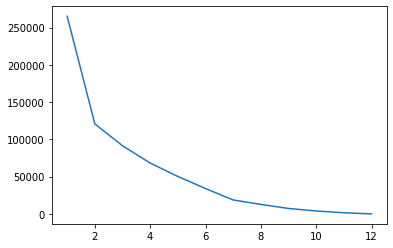

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
plt.plot(one_to_features_num,inertia)

Как видно, подходящее значение числа кластеров - 7. Смотрим на получившееся распределение по кластерам.

In [ ]:
km.set_params(n_clusters = 7,n_init = 1000)
km.fit(data_count)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=1000, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
def get_clusters_dict(km,data):
  clusters_dict = {}
  for i in range(km.n_clusters):
    clusters_dict[i] = []
  for i in range(len(km.labels_)):
    clusters_dict[km.labels_[i]].append(data.index[i])
  return clusters_dict
get_clusters_dict(km,data_count)

{0: ['ЛДПР', 'Яблоко', 'РПСС', 'Зеленая альтернатива', 'Партия роста'],
 1: ['Гражданская платформа'],
 2: ['Партия пенсионеров'],
 3: ['Родина'],
 4: ['Зеленые'],
 5: ['Новые люди'],
 6: ['КПРФ', 'Коммунисты России']}

Как видно, не получилась хорошая кластеризация, поэтому далее будем использовать tf и tf-idf.

Проводим аналогичные действия для tf.

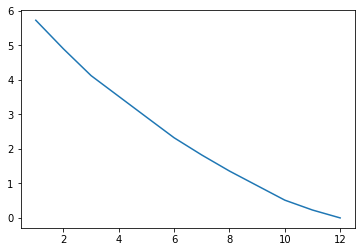

In [ ]:
inertia = []
for i in one_to_features_num:
  km.set_params(n_clusters = i,n_init = 100)
  km.fit(data_tf)
  inertia.append(km.inertia_)
plt.plot(one_to_features_num,inertia)

И теперь с td-idf.

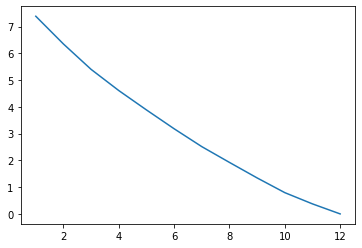

In [ ]:
inertia = []
for i in one_to_features_num:
  km.set_params(n_clusters = i,n_init = 100)
  km.fit(data_tf_idf)
  inertia.append(km.inertia_)
plt.plot(one_to_features_num,inertia)

Как видно, для tf и tf idf k-means не дает определить нужного количества кластеров. Посмотрим, как кластера могут выглядеть.

In [ ]:
km.set_params(n_clusters = 7,n_init = 1000)
km.fit(data_tf)
get_clusters_dict(km,data_tf)

{0: ['КПРФ', 'Коммунисты России'],
 1: ['Партия пенсионеров', 'Родина'],
 2: ['Новые люди', 'Партия роста', 'Гражданская платформа'],
 3: ['Зеленая альтернатива'],
 4: ['Яблоко', 'Зеленые'],
 5: ['РПСС'],
 6: ['ЛДПР']}

In [ ]:
km.set_params(n_clusters = 7,n_init = 1000)
km.fit(data_tf_idf)
get_clusters_dict(km,data_tf_idf)

{0: ['Яблоко'],
 1: ['Новые люди', 'Партия роста', 'Гражданская платформа'],
 2: ['Зеленые', 'Зеленая альтернатива'],
 3: ['РПСС'],
 4: ['КПРФ', 'Коммунисты России'],
 5: ['Партия пенсионеров', 'Родина'],
 6: ['ЛДПР']}

### Пункты

Кластеризуем пункты. Так как это занимает много времени, ограничиваем количество проводимых кластеризаций.

In [ ]:
from sklearn import cluster
km = cluster.KMeans()
one_to_features_num = [i+1 for i in range(puncts_count.shape[0])]
limit = 20
inertia = []
for i in one_to_features_num[:limit]:
  km.set_params(n_clusters = i,n_init = 100)
  km.fit(puncts_count)
  inertia.append(km.inertia_)

Строим график зависимости inertia от числа кластеров. 

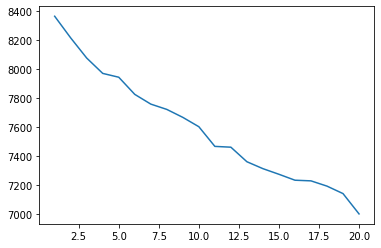

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
plt.plot(one_to_features_num[:limit],inertia)

Посмотрим разделение на кластера для одного из локтей.

In [ ]:
km.set_params(n_clusters = 11,n_init = 100)
km.fit(puncts_count)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
for i in get_clusters_dict(km,puncts_count).items(): print (len(i[1]))

23
1
1
1
41
10
336
1
1
1
1


Разделение получилось плохим, кластера слишком разного размера.

Проводим аналогичные действия для tf.

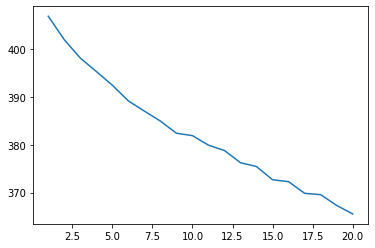

In [ ]:
inertia = []
for i in one_to_features_num[:limit]:
  km.set_params(n_clusters = i,n_init = 100)
  km.fit(puncts_tf)
  inertia.append(km.inertia_)
plt.plot(one_to_features_num[:limit],inertia)

Возьмем первый локоть - 9.

In [ ]:
km.set_params(n_clusters = 9,n_init = 100)
km.fit(puncts_tf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Смотрим длины кластеров

In [ ]:
for i in get_clusters_dict(km,puncts_tf).items(): print (len(i[1]))

33
63
34
48
44
125
33
17
20


Создадим функцию, которая выводит те слова, которые встречаются в кластере в наиболее большое число раз чаще, чем в среднем по датасету.

In [ ]:
def often_words(km,cluster_num,data):
  in_cluster_data = data[km.labels_==cluster_num]
  rel = in_cluster_data.mean()/data.mean()
  return rel.sort_values().tail(50)

In [ ]:
often_words(km,0,puncts_tf)

импортозамещение       12.636364
импортировать          12.636364
благоустраиваться      12.636364
президиум              12.636364
июнь                   12.636364
болото                 12.636364
уставный               12.636364
полноценный            12.636364
стабильный             12.636364
защищённость           12.636364
аналоговый             12.636364
пресечение             12.636364
престиж                12.636364
перевести              12.636364
зай                    12.636364
конфисковать           12.636364
корреспондент          12.636364
урна                   12.636364
хозяйка                12.636364
обитание               12.636364
входить                12.636364
спасение               12.636364
вынуждать              12.636364
конкурентоспособный    12.636364
отличный               12.636364
выгодно                12.636364
кормилец               12.636364
комфортно              12.636364
воля                   12.636364
жизненно               12.636364
талант    

In [ ]:
often_words(km,1,puncts_tf)

валюта               6.619048
конституционный      6.619048
нелегальный          6.619048
внутрь               6.619048
избирательный        6.619048
зато                 6.619048
финансово            6.619048
ледовитый            6.619048
временно             6.619048
поезд                6.619048
нераспространение    6.619048
неравенство          6.619048
след                 6.619048
скорость             6.619048
вступление           6.619048
сибирь               6.619048
поиск                6.619048
хозяин               6.619048
въезд                6.619048
холодный             6.619048
выбор                6.619048
запад                6.619048
вывести              6.619048
сверхдержава         6.619048
несырьевой           6.619048
спецслужба           6.619048
сменяемость          6.619048
нефтегазовый         6.619048
ухудшать             6.619048
воздух               6.619048
концепция            6.619048
питьевой             6.619048
золотовалютный       6.619048
возобновле

In [ ]:
often_words(km,2,puncts_tf)

укрупнение           12.264706
основополагающий     12.264706
приходить            12.264706
койка                12.264706
инструмент           12.264706
тарификация          12.264706
разумный             12.264706
иметься              12.264706
терапия              12.264706
протокол             12.264706
замена               12.264706
техник               12.264706
продолжительность    12.264706
технологичный        12.264706
кластер              12.264706
изделие              12.264706
анализ               12.264706
амбулаторный         12.264706
значительно          12.264706
выхаживание          12.264706
назначить            12.264706
обоснование          12.264706
замещать             12.264706
удержание            12.264706
абсолютный           12.264706
стационар            12.264706
различие             12.264706
актуализация         12.264706
биотехнология        12.264706
ранее                12.264706
квалифицировать      12.264706
межрегиональный      12.264706
инфляция

In [ ]:
def often_words2(km,cluster_num,data):
  in_cluster_data = data[km.labels_==cluster_num]
  rel = in_cluster_data.mean()
  return rel.sort_values().tail(50)

И теперь с td-idf.

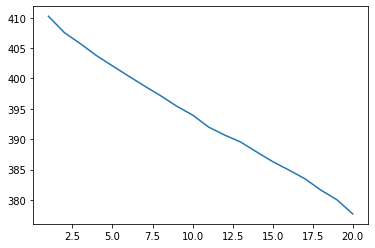

In [ ]:
inertia = []
for i in one_to_features_num[:limit]:
  km.set_params(n_clusters = i,n_init = 100)
  km.fit(puncts_tf_idf)
  inertia.append(km.inertia_)
plt.plot(one_to_features_num[:limit],inertia)

In [ ]:
km.set_params(n_clusters = 11,n_init = 100)
km.fit(puncts_tf_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
for i in get_clusters_dict(km,puncts_tf_idf).items(): print (len(i[1]))

29
50
55
51
23
34
59
35
14
22
45


In [ ]:
often_words(km,0,puncts_tf_idf)

взгляд              14.37931
благоприятный       14.37931
приводить           14.37931
обитатель           14.37931
бороться            14.37931
возведение          14.37931
ископаемое          14.37931
поэтому             14.37931
человечество        14.37931
достоверный         14.37931
сверхприбыль        14.37931
логичный            14.37931
еда                 14.37931
лишь                14.37931
просвещение         14.37931
кризис              14.37931
выбивать            14.37931
крестьянско         14.37931
планета             14.37931
рента               14.37931
коллекторский       14.37931
коллектор           14.37931
угодье              14.37931
изменить            14.37931
хотеть              14.37931
топливо             14.37931
производственно     14.37931
целенаправленный    14.37931
причинить           14.37931
парниковый          14.37931
навязчивый          14.37931
ущерб               14.37931
мошенник            14.37931
последовательный    14.37931
служить       

In [ ]:
often_words(km,1,puncts_tf_idf)

полиграф             8.34
педофил              8.34
поэтапно             8.34
проверять            8.34
коррекционный        8.34
фактически           8.34
малоимущий           8.34
разрыв               8.34
обоснование          8.34
задержать            8.34
инвалидность         8.34
контрольный          8.34
хартия               8.34
уделять              8.34
животноводческий     8.34
сохранность          8.34
труженик             8.34
софинансирование     8.34
накопление           8.34
тыл                  8.34
актуализация         8.34
методика             8.34
ниже                 8.34
механический         8.34
акционер             8.34
отчёт                8.34
микрозаём            8.34
хозяйственный        8.34
бывший               8.34
дифференцирование    8.34
предварительно       8.34
антирусский          8.34
заложник             8.34
хотя                 8.34
создатель            8.34
надзор               8.34
основание            8.34
заместитель          8.34
сгореть     

В обоих методах векторизации вывелись те слова,  которые уникальны для каждого кластера, но не образуют какой-либо смысл вместе для кластера.

## Иерархическая кластеризация

### Партии

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
ac = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

Делаем функцию для удобного вывода дендрограммы (https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py).

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

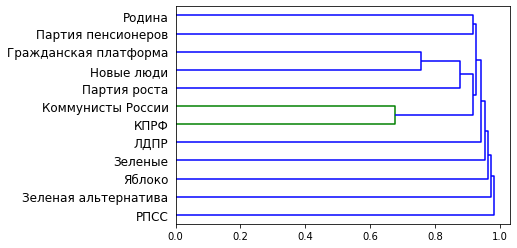

In [ ]:
plot_dendrogram(ac.set_params(linkage='single').fit(data_tf),labels=data_count.index,orientation='right')

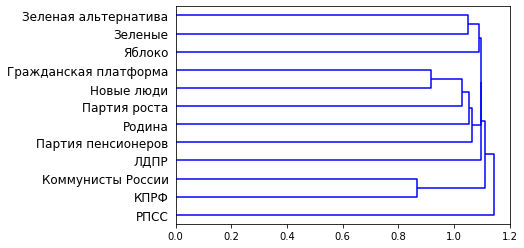

In [ ]:
plot_dendrogram(ac.set_params(linkage='single').fit(data_tf_idf),labels=data_count.index,orientation='right')

Теперь ward.

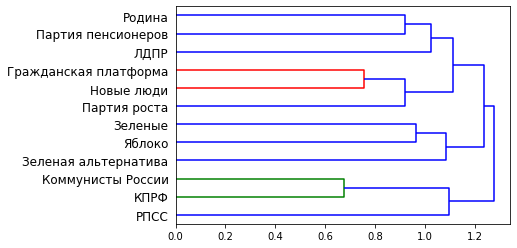

In [ ]:
plot_dendrogram(ac.set_params(linkage='ward').fit(data_tf),labels=data_count.index,orientation='right')

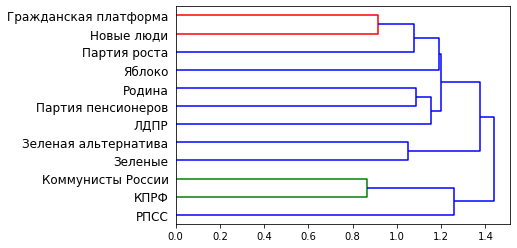

In [ ]:
plot_dendrogram(ac.set_params(linkage='ward').fit(data_tf_idf),labels=data_count.index,orientation='right')

### Пункты

Кластеризуем пункты

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
ac = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

Заново переопределяем методы, созданные выше, чтобы не нужно было исполнять те куски кода.

In [ ]:
def often_words(model,cluster_num,data):
  in_cluster_data = data[model.labels_==cluster_num]
  rel = in_cluster_data.mean()/data.mean()
  return rel.sort_values().tail(10)

In [ ]:
def get_clusters_dict(model,data):
  clusters_dict = {}
  for i in range(model.n_clusters):
    clusters_dict[i] = []
  for i in range(len(model.labels_)):
    clusters_dict[model.labels_[i]].append(data.index[i])
  return clusters_dict

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

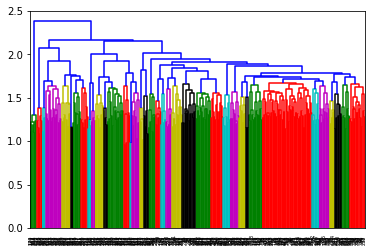

In [ ]:
plot_dendrogram(ac.set_params(linkage='ward').fit(puncts_tf_idf),labels=puncts_count.index)

Проводим иерархическую кластеризацию со всеми возможными метриками расстояния, методами, датасетами.

In [ ]:
def big_test(datasets,n_clust):
  num =0
  for j in range(len(datasets)):
    dataset = datasets[j]
    for method in ['single','complete','average','ward']:
      for metric in ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']:
        if not (method=='ward' and metric!='euclidean'):
          ac = AgglomerativeClustering(n_clusters=n_clust,affinity=metric,linkage=method).fit(dataset)
          clust_lens = [len(i) for i in get_clusters_dict(ac,dataset).values()]
          if len([i for i in clust_lens if i<=5])>=n_clust/2: continue # Если много маленьких кластеров
          if len([i for i in clust_lens if i>=len(puncts_count)/2])>=1: continue # Если один большой кластер, в которого входят большинство записей
          num+=1
          print('dataset:',['count','tf','tf-idf'][j],'method:',method,'metric:',metric)
          print('Количество записей в кластерах:')
          for i in clust_lens: print (i)
          print('Характерные слова:')
          for i in range(n_clust):
            print(often_words(ac,i,dataset))
  print('Количество кластеризаций: ',num)
datasets = [puncts_count, puncts_tf,puncts_tf_idf]
big_test(datasets,n_clust=10)

dataset: count method: complete metric: precomputed
Количество записей в кластерах:
134
2
30
6
63
65
13
102
1
1
Характерные слова:
округ            3.11194
визовый          3.11194
слышать          3.11194
видеосъёмка      3.11194
взять            3.11194
взятка           3.11194
ознакомление     3.11194
однопартийный    3.11194
загубить         3.11194
пресечь          3.11194
dtype: float64
фактор           139.0
наоборот         208.5
рассчитывать     208.5
обязательно      208.5
фальсификатор    208.5
угрожать         208.5
влияние          208.5
махинатор        208.5
насколько        208.5
настолько        208.5
dtype: float64
ничтожно       13.9
порт           13.9
доходный       13.9
самооборона    13.9
самобытный     13.9
уменьшение     13.9
процветать     13.9
госзакупка     13.9
арена          13.9
ствие          13.9
dtype: float64
возведение           69.5
сумма                69.5
норматив             69.5
45                   69.5
погоня               69.5
it            

Комбинации, которые дали хоть какое то ощущение разделения:

dataset: tf-idf method: complete metric: euclidean

dataset: tf-idf method: average metric: euclidean

Почти во всех вариантах коэффициенты частых слов в кластере одинаковые. Это из-за того, что всегда сюда помещаются слова, которые используются только в 1 кластере, очень редкие слова. Как видно, они не дали нормальной интерпретации кластеров.
Удалим из датасетов редкие слова, до такой степени, чтобы это начало существенно отражаться на коэффициентах частных слов кластеризаций.

In [ ]:
puncts_sum = puncts_count.sum(axis = 0)
cols_no_rare_words = [i for i in puncts_sum.index if puncts_sum[i]>2]
puncts_count_no_rare_words = puncts_count[cols_no_rare_words]
puncts_tf_no_rare_words = puncts_tf[cols_no_rare_words]
puncts_tf_idf_no_rare_words = puncts_tf_idf[cols_no_rare_words]

Снова проводим кластеризацию.

In [ ]:
datasets = [puncts_count_no_rare_words, puncts_tf_no_rare_words,puncts_tf_idf_no_rare_words]
big_test(datasets,n_clust=10)

dataset: count method: complete metric: precomputed
Количество записей в кластерах:
61
39
74
27
64
84
18
48
1
1
Характерные слова:
перспективный        4.557377
автомобиль           4.557377
школьный             4.557377
значение             4.557377
провести             4.557377
индексация           4.557377
ценность             4.557377
выброс               5.127049
геронтологический    5.696721
понятие              6.836066
dtype: float64
земельный           7.128205
20                  7.128205
оборона             7.128205
являться            7.128205
преступление        7.128205
долгосрочный        8.019231
монополия           8.019231
ядерный            10.692308
антимонопольный    10.692308
естественный       10.692308
dtype: float64
язык            3.756757
пропаганда      4.226351
рассмотрение    4.226351
исключение      4.226351
дума            4.226351
чистый          4.695946
внешний         4.695946
направлять      5.635135
самооборона     5.635135
угольный        5.635135

Наиболее адекватно повела себя комбинация: dataset: tf-idf method: average metric: cosine

Для каждой кластеризации мы выводим 10*10 слов, хорошо если это будут самые частые слова, такое будет, если в датасете примерно столько слов. Тогда удалим слова из датасета до того момента, пока в нем не останется 100 слов, или же один из его записей станет нулевым вектором. 

In [ ]:
for j in range(1,50):
  cols_no_rare_words = [i for i in puncts_sum.index if puncts_sum[i]>j]
  puncts_count_no_rare_words = puncts_count[cols_no_rare_words]
  if np.any(~np.any(puncts_count_no_rare_words, axis=1)) or len(cols_no_rare_words)<100:
    k = j-1
    break
print('k =',k)
cols_no_rare_words = [i for i in puncts_sum.index if puncts_sum[i]>k]
puncts_count_no_rare_words = puncts_count[cols_no_rare_words]
puncts_tf_no_rare_words = puncts_tf[cols_no_rare_words]
puncts_tf_idf_no_rare_words = puncts_tf_idf[cols_no_rare_words]

k = 3


In [ ]:
datasets = [puncts_count_no_rare_words, puncts_tf_no_rare_words,puncts_tf_idf_no_rare_words]
big_test(datasets,n_clust=10)

dataset: count method: complete metric: precomputed
Количество записей в кластерах:
14
4
22
67
31
60
71
36
61
51
Характерные слова:
будущее         7.446429
исходить        7.446429
строить         7.446429
многодетный     7.446429
частность       7.446429
негативный      7.446429
налоговый       8.123377
стать           8.510204
комплекс        9.928571
учитывать      14.892857
dtype: float64
сми              17.3750
наказание        20.8500
военный          20.8500
будущее          26.0625
мировой          26.0625
настоящий        26.0625
реклама          26.0625
учитывать        26.0625
ликвидировать    26.0625
здоровый         34.7500
dtype: float64
ответственность    5.686364
военный            5.686364
бюджетный          6.318182
соблюдение         6.318182
задача             6.318182
стандарт           6.892562
ужесточить         7.107955
национальный       7.290210
пересмотреть       7.581818
достойный          8.424242
dtype: float64
требование        3.111940
приватизация    

Лучшие комбинации:

dataset: tf method: ward metric: euclidean

dataset: tf-idf method: average metric: cosine

Последняя комбинация хорошо себя повела уже в 2 вариантах кластеризации. Попробуем ее. Раскраска соответствует тому, как визуально должны разделяться кластера. 

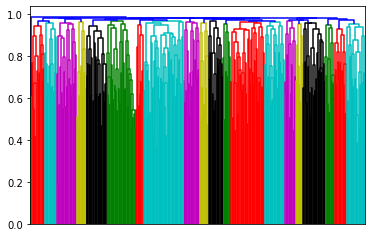

In [ ]:
puncts_sum = puncts_count.sum(axis = 0)
cols_no_rare_words = [i for i in puncts_sum.index if puncts_sum[i]>3]
puncts_tf_idf_no_rare_words = puncts_tf_idf[cols_no_rare_words]
ac = AgglomerativeClustering(distance_threshold=0,n_clusters=None,affinity='cosine',linkage='average')
plot_dendrogram(ac.fit(puncts_tf_idf_no_rare_words),labels=puncts_count.index,color_threshold=0.9673,no_labels=True)

In [ ]:
def often_words(model,cluster_num,data):
  in_cluster_data = data[model.labels_==cluster_num]
  rel = in_cluster_data.mean()/data.mean()
  return rel.sort_values().tail(20)

In [ ]:
n_clusters = 21
ac = AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='average').fit(puncts_tf_idf_no_rare_words)
clust_lens = [len(i) for i in get_clusters_dict(ac,puncts_tf_idf_no_rare_words).values()]
print('Количество записей в кластерах:')
for i in range(len(clust_lens)): print (i+1,': ',clust_lens[i])
print('Характерные слова:')
for i in range(n_clusters): print('Кластер ',i+1,'\n',often_words(ac,i,puncts_tf_idf_no_rare_words))

Количество записей в кластерах:
1 :  50
2 :  37
3 :  18
4 :  12
5 :  25
6 :  27
7 :  14
8 :  10
9 :  19
10 :  42
11 :  11
12 :  15
13 :  25
14 :  10
15 :  23
16 :  2
17 :  25
18 :  15
19 :  9
20 :  16
21 :  12
Характерные слова:
Кластер  1 
 положение          5.069325
пункт              5.445307
квалификация       5.545685
активный           5.648537
минимум            5.696307
здравоохранение    6.071497
страхование        6.243735
перечень           6.337740
лекарственный      6.356772
старший            6.402213
экспорт            6.456563
препарат           6.543102
2017               6.551738
медицинский        6.932129
информационный     6.933532
врач               7.110896
основный           7.145718
оказание           8.340000
пациент            8.340000
гериатрический     8.340000
dtype: float64
Кластер  2 
 порядок             6.154399
соответствующий     6.312982
каждый              6.735726
пенсионер           6.785854
сша                 6.837283
представитель       6.942

Интерпретируем результаты кластеризации.

Некоторые кластера можно охарактеризовать сразу, про них будет дальше. Посмотрим на те кластера, которые сложно охарактеризовать.

In [ ]:
puncts_df[ac.labels_==3] # Кластер 4

,Партия,Пункт,Тема
80,ЛДПР,Принять закон «О профориентации». Вводить про...,ОБРАЗОВАНИЕ И НАУКА
100,ЛДПР,Принять закон «О конфискации автомобиля у пья...,ПРАВОПОРЯДОК
134,Партия пенсионеров,разработку и принятие современного стандарта к...,Пенсионная реформа:
157,Партия пенсионеров,развертывание широкомасштабных научных исследо...,Реформа здравоохранения:
189,Партия пенсионеров,"введение «паспорта здоровья пенсионера», котор...",Экономическая политика:
217,Партия пенсионеров,разработку и принятие федерального закона «О п...,Сельское хозяйство :
264,Коммунисты России,введение закона «О сверхдоходах»;,NaN
265,Коммунисты России,Введение в систему социальной защиты населени...,NaN
267,Коммунисты России,принятие радикальных мер по улучшению качеств...,NaN
268,Коммунисты России,принятие решительных мер по охране детства;,NaN


In [ ]:
list(puncts_df['Пункт'][ac.labels_==3]) # Кластер 4

[' Принять закон «О профориентации». Вводить профориентацию в школе. За государственный счет готовить кадры только для востребованных профессий.',
 ' Принять закон «О конфискации автомобиля у пьяных водителей». Пожизненно лишать водительских прав за неоднократное вождение автомобиля в нетрезвом виде или в состоянии наркотического опьянения.',
 'разработку и принятие современного стандарта качества жизни пенсионера;',
 'развертывание широкомасштабных научных исследований в области геронтологии, введении специализированных премий Правительства Российской Федерации за научные достижения по специальности "Гериатрия", изучение возможности введения специализированных вакансий академиков и членов – корреспондентов РАН по вопросам гериатрии;',
 'введение «паспорта здоровья пенсионера», который бы обеспечивал ежегодную медицинскую помощь, включал услуги стоматологии и другие виды платных услуг;',
 'разработку и принятие федерального закона «О преференциях»;',
 ' введение закона «О сверхдоходах»

В этот кластер попали записи, где предлагается принять какой-то закон, и эта информация пересиливает содержание каждого конкретного предложения закона

In [ ]:
puncts_df[ac.labels_==6] # Кластер 7

,Партия,Пункт,Тема
19,КПРФ,оградить общество от пропаганды пошлости и ци...,NaN
53,ЛДПР,Запретить русофобскую пропаганду в СМИ и на у...,РУССКИЕ И ДРУГИЕ НАРОДЫ РОССИИ
143,Партия пенсионеров,отказ от коммерческих страховых компаний в сис...,Реформа здравоохранения:
173,Партия пенсионеров,поддержку предложения представителей Обществен...,Реформа образования и социальная адаптация:
233,Яблоко,Политическая свобода. Освобождение всех полит...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
234,Яблоко,Раскрытие политических преступлений. Расследо...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
237,Яблоко,Свобода слова и творчества. Запрет на все вид...,"СВОБОДА, ПРАВА ЧЕЛОВЕКА, ДЕМОКРАТИЯ, ЖИЗНЬ БЕЗ..."
249,Яблоко,"Развитие «зеленой» энергетики, переход на низ...",ЭКОЛОГИЯ: ЧИСТЫЙ ВОЗДУХ И ВОДА
253,Яблоко,Нет войне. Отказ от участия России в вооружен...,"ВНЕШНЯЯ ПОЛИТИКА: ДРУЗЬЯ, А НЕ ВРАГИ"
272,Зеленые,"Выработка, совершенствование и осуществление д...",NaN


In [ ]:
list(puncts_df['Пункт'][ac.labels_==6]) # Кластер 4

[' оградить общество от пропаганды пошлости и цинизма в СМИ, осуществить доступ в государственные средства массовой информации всех политических сил, действующих в рамках закона, прекратить очернение российской и советской истории;',
 ' Запретить русофобскую пропаганду в СМИ и на улицах. Ввести уголовное наказание за растрату государственных денег на создание русофобских СМИ и интернет-порталов.',
 'отказ от коммерческих страховых компаний в системе ОМС;',
 'поддержку предложения представителей Общественной палаты Российской Федерации о полном отказе в будущем от любой монетизации льгот.',
 ' Политическая свобода. Освобождение всех политических заключенных. Отмена репрессивных законов, ограничивающих права и свободы человека и гражданина. Отмена «обнуления» президентских сроков и восстановление конституционного порядка. Свобода собраний и митингов. Десталинизация и честная оценка советского периода',
 ' Раскрытие политических преступлений. Расследование отравления А. Навального, убийст

Этот кластер не охарактеризовать четко

In [ ]:
puncts_df[ac.labels_==10] # Кластер 11

,Партия,Пункт,Тема
22,КПРФ,обеспечить территориальную целостность России...,NaN
44,ЛДПР,Запретить называть улицы и города именами тер...,РЫВОК ВПЕРЕД!
69,ЛДПР,Снять все ограничения на выезд за рубеж росси...,СОЦИАЛЬНАЯ ПОЛИТИКА
70,ЛДПР,Запретить давать кредит под залог единственно...,СОЦИАЛЬНАЯ ПОЛИТИКА
71,ЛДПР,Запретить коллекторскую деятельность. Коллект...,СОЦИАЛЬНАЯ ПОЛИТИКА
88,ЛДПР,Запретить ввоз ГМО и вернуть ГОСТы. Запретить...,ЗДОРОВЬЕ И ЭКОЛОГИЯ
95,ЛДПР,Обеспечить тишину и покой во всех городах и н...,ЗДОРОВЬЕ И ЭКОЛОГИЯ
103,ЛДПР,Запретить продавать за рубеж необработанное с...,ЭКОНОМИКА
111,ЛДПР,Вывести золотовалютные резервы России из амер...,ЭКОНОМИКА
176,Партия пенсионеров,разработку обучающих материалов для лиц с огра...,Реформа образования и социальная адаптация:


In [ ]:
list(puncts_df['Пункт'][ac.labels_==10]) # Кластер 11

[' обеспечить территориальную целостность России и защиту соотечественников за рубежом;',
 ' Запретить называть улицы и города именами террористов, революционеров и бандитов. Переименовать таковые именами великих сынов Отечества: ученых, полководцев, государственных деятелей, народных артистов и т.\u200aд.',
 ' Снять все ограничения на выезд за рубеж российских граждан из-за долгов по кредитам и зай-',
 ' Запретить давать кредит под залог единственного жилья. Недопустимо, когда люди лишаются квартир и домов.',
 ' Запретить коллекторскую деятельность. Коллекторы выбивают из людей долги, появившиеся в результате действий мошенников или навязчивой и недостоверной рекламы кредитных организаций.',
 ' Запретить ввоз ГМО и вернуть ГОСТы. Запретить рекламу любой еды. Такая реклама приводит к ожирению и множеству болезней.',
 ' Обеспечить тишину и покой во всех городах и населенных пунктах от шума машин, мотоциклов, музыки, строительных работ и т.\u200aд.',
 ' Запретить продавать за рубеж необр

Этот кластер не охарактеризовать четко

In [ ]:
puncts_df[ac.labels_==12]

,Партия,Пункт,Тема
16,КПРФ,повысить эффективность системы государственно...,NaN
20,КПРФ,принять самые решительные меры для подавления...,NaN
30,ЛДПР,Обязать любого руководителя брать заместителе...,ПОЛИТИКА И ВЛАСТЬ
67,ЛДПР,Легализовать любые виды «серых» зарплат. Нужн...,СОЦИАЛЬНАЯ ПОЛИТИКА
98,ЛДПР,Дать право законопослушным гражданам на испол...,ПРАВОПОРЯДОК
99,ЛДПР,Лишать осужденных за коррупцию чиновников пен...,ПРАВОПОРЯДОК
101,ЛДПР,Использовать полиграф для контроля работы чин...,ПРАВОПОРЯДОК
241,Яблоко,Противодействие коррупции. Сокращение закрыты...,СОВРЕМЕННАЯ ЭКОНОМИКА
254,Яблоко,Предотвращение ядерной войны. Укрепление дого...,"ВНЕШНЯЯ ПОЛИТИКА: ДРУЗЬЯ, А НЕ ВРАГИ"
257,Яблоко,Доверие и сотрудничество. Кооперация России и...,"ВНЕШНЯЯ ПОЛИТИКА: ДРУЗЬЯ, А НЕ ВРАГИ"


In [ ]:
list(puncts_df['Пункт'][ac.labels_==12])

[' повысить эффективность системы государственного управления, сократить число чиновников, расширить права трудовых коллективов и профсоюзов;',
 ' принять самые решительные меры для подавления коррупции и преступности, пресечь практику искусственных банкротств, поставить заслон рейдерским захватам;',
 ' Обязать любого руководителя брать заместителей из оппозиционных парламентских партий. Закрепить за оппозицией функции надзора и контроля.',
 ' Легализовать любые виды «серых» зарплат. Нужно платить не в конвертах, а официальную заработную плату. Обязать работодателей заключать трудовые договоры.',
 ' Дать право законопослушным гражданам на использование оружия для защиты жилища, а также своей жизни от диких животных.',
 ' Лишать осужденных за коррупцию чиновников пенсий, доступа к бесплатной медицине и прочей социальной поддержки государства. Чиновника за взятку увольнять с конфискацией имущества.',
 ' Использовать полиграф для контроля работы чиновников, которые отвечают за государстве

Тут что то про чиновников, но не только.

In [ ]:
puncts_df[ac.labels_==13]

,Партия,Пункт,Тема
94,ЛДПР,В федеральном масштабе развернуть программы п...,ЗДОРОВЬЕ И ЭКОЛОГИЯ
106,ЛДПР,"Ввести госмонополию на алкоголь, сахар, табак...",ЭКОНОМИКА
107,ЛДПР,"Легализовать теневой бизнес, проведя экономич...",ЭКОНОМИКА
318,Родина,законодательно обеспечить широкую пропаганду з...,семейной и молодежной политики
328,Родина,запустить комплексную программу замещения 50% ...,финансово-экономической политики
401,Зеленая альтернатива,"Помимо этого, целям экологического просвещения...",Образование
407,Зеленая альтернатива,Россия может и должна быть страной здоровых пр...,Экономика
408,Зеленая альтернатива,"Появление новых болезней и вирусов, огромное к...",Здравоохранение
414,Зеленая альтернатива,Здоровое будущее великой стране,Развитие территорий.
416,Зеленая альтернатива,Наша партия предлагает здоровую и логичную аль...,Развитие территорий.


In [ ]:
list(puncts_df['Пункт'][ac.labels_==13])

[' В федеральном масштабе развернуть программы помощи для отказа от алкоголя и табака. Снизить смертность и количество заболеваний от вредных привычек.',
 ' Ввести госмонополию на алкоголь, сахар, табак и энергоресурсы — это огромные доходы. Вернуть в госуправление крупные торговые сети, энергетические компании и стратегические предприятия.',
 ' Легализовать теневой бизнес, проведя экономическую амнистию и гарантировав тайну вкладов. Это вернет из-за границы огромные деньги — 8 годовых бюджетов.',
 'законодательно обеспечить широкую пропаганду здорового образа жизни, норм физического и нравственного здоровья, особенно среди молодежи;',
 'запустить комплексную программу замещения 50% нынешнего импорта, что обеспечит 10-12 триллионов рублей в год дополнительных инвестиций с гарантированными источниками возврата (практически все эти деньги в конечном итоге пойдут на зарплаты, пенсии и в доходы бюджета; при этом резко увеличится монетизация экономики и появится источник «длинных» денег за 

Этот кластер не охарактеризовать четко

В то же время остальные кластера с большой точности вобрали в себя похожие записи, вот пример - кластер про здравоохранение:

In [ ]:
list(puncts_df['Пункт'][ac.labels_==0])[:20]

[' Троекратно повысить базовые оклады медикам. Врач должен думать о здоровье пациента, а не о том, как сэкономить деньги.',
 ' Перейти на 100%-ное федеральное финансирование системы здравоохранения. Бесплатно вакцинировать граждан и обеспечивать их медицинскими лекарственными препаратами в период эпидемий.',
 ' Усовершенствовать систему закупок техники для больниц, поликлиник и фельдшерско-акушерских пунктов за счет экономии на бюрократических согласованиях.',
 ' Повысить кадровую обеспеченность медицинских учреждений.',
 ' Особое внимание уделять высокотехнологическим предприятиям. Минимум проверок и максимум льгот. Развивать экспорт электроэнергии.',
 'разработку на основе материалов Президиума Государственного Совета "О развитии системы социальной защиты граждан пожилого возраста" (июнь 2014 года) и "Стратегии действий в интересах граждан старшего поколения в Российской Федерации до 2025 года", с учетом основных положений Программы Политической партии "Российская партия пенсионеров 

Получилась такая интерпретация кластеров:

1 - здравоохранение

2 - пенсионеры

3 - политика

4 - принятие какого-то конкретного закона

5 - семья и инфраструктура

6 - экономика и промышленность.

7

8 - жкх

9 - что то про налоги

10 - культура и народы россии

11

12 - образование

13 - что то про чиновников, но не только.

14

15 - предпринимательство

16 - что то про бюджет государства

17 - экология

18 - сельское хозяйство

19 - промышленность

20 - про размер оплаты труда и пособия

21 - питание

Под 3 кластером следует понимать Государственное устройство, ввиду характерных для этого слов, таких как "местный", "самоуправление", "выборы", "свободный", "независимый".

Сохраняем результаты кластеризации.

In [ ]:
cluster_res = open('/content/drive/MyDrive/Colab Notebooks/Проект/Результаты кластеризации.txt','w')
cluster_res.write(str(ac.labels_))
cluster_res.close()
cluster_res_interpret = open('/content/drive/MyDrive/Colab Notebooks/Проект/Интерпретация результатов кластеризации.txt','w')
interpret_list = ['здравоохранение','пенсионеры','политика','принятие какого-то конкретного закона','семья и инфраструктура','экономика и промышленность.',
                  '7','жкх','налоги','культура и народы россии','11','образование','что-то про чиновников, но не только.','14','предпринимательство',
                  'что-то про бюджет государства','экология','сельское хозяйство','промышленность','про размер оплаты труда и пособия','питание']
cluster_res_interpret.write('\n'.join(interpret_list))
cluster_res_interpret.close()

# Выводы

Определились сферы, в которых партии, согласно их программам, собираются проводить политику. Это: здравоохранение, пенсионеры, Государственное устройство, семья и инфраструктура, экономика и промышленность, жкх, налоговая политика, культура и народы россии, образование,
работа чиновников, предпринимательство, бюджет государства, экология, сельское хозяйство, промышленность,размер оплаты труда и пособия, питание.
